# Initialize

## Initialization

In [3]:
import os
import json
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
import pandas as pd
from timeit import default_timer as timer
from jupyterthemes import jtplot
jtplot.reset()
sys.path.append('../code')
import Bijectors,Distributions,Metrics,MixtureDistributions,Plotters,Trainer,Utils
paper_fig_dir = "../../../NormalizingFlows/papers/NFHD/figures/"

## Useful functions

In [4]:
def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [5]:
def MixtureGaussian(ncomp,ndims,seed=0):
    targ_dist = MixtureDistributions.MixMultiNormal1(ncomp,ndims,seed=seed)
    return targ_dist

In [6]:
def build_data_from_runs(path,save_file_name,only_succeeded=True):
    if only_succeeded:
        result_string = "succeeded"
    else:
        result_string = "all"
    print("Processing path", path,"for",result_string,"runs.")
    runs_list=[[int(i.replace("run_","")),os.path.abspath(os.path.join(os.path.join(path,i),"results.txt"))] for i in os.listdir(path) if ("run" in i and os.path.isdir(os.path.abspath(os.path.join(path,i))))]
    runs_list.sort()
    i=0
    j=0
    data=pd.DataFrame()
    for run in runs_list:
        proceed = True
        try:
            if os.path.exists(run[1]):
                print(run[1])
                tmp = pd.read_csv(run[1])#.pop("time")
                if 'nan' in str(tmp) or "failed" in str(tmp):
                    if not only_succeeded:
                        proceed = True
                    else:
                        proceed = False
                else:
                    proceed = True
                if not 'pippo' in str(tmp):
                    tmp = recompute_metrics(run[1])
                else:
                    pass
                if proceed:
                    data=pd.concat([data,tmp])
                else:
                    pass
                i=i+1
            else:
                j=j+1
                print("No results available for run",run[0])
        except:
            j=j+1
            print("Failed to import run",run[0])
    data = data.reset_index(drop=True).replace("failed","nan")
    print("Succesfully imported", i, "runs (failed to import",j,"runs).")
    save_path = os.path.abspath(os.path.join(path,save_file_name))
    data.to_csv(save_path,index=False)
    print("Succesfully saved data to file", save_path)
    return data

In [7]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    start=timer()
    ks_mean,ks_std,ad_mean,ad_std,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'ks_mean':[ks_mean],
                    'ks_std':[ks_std],
                    'ad_mean':[ad_mean],
                    'ad_std':[ad_std],
                    'wd_mean':[wd_mean],
                    'wd_std':[wd_std],
                    'swd_mean':[swd_mean],
                    'swd_std':[swd_std],
                    'fn_mean':[fn_mean],
                    'fn_std':[fn_std],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    #os.rename(run, run.replace(".txt","_old.txt"))
    Utils.results_current(run.replace("results.txt",""),results_dict)
    tmp_new = pd.read_csv(run)
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp_new

In [8]:
def extract_lines(df_bests,bij,corr,metric,mean_std=False):
    result = []
    for df in df_bests:
        if mean_std:
            tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric+"_mean",metric+"_std","run_n"]].to_numpy().flatten().tolist()
        else:
            tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
        if tmp != []:
            result.append(tmp)
    return np.array(result)

## Check, fix, import results

### Check and fix results

In [9]:
correlated_results_paths = {"MAFN": "../CMoG/results/MAFN/",
                           "RealNVPN": "../CMoG/results/RealNVPN/",
                           "MsplineN": "../CMoG/results/MsplineN/",
                           "CsplineN": "../CMoG/results/CsplineN/"
                          }
correlated_unc_results_paths = {"MAFN": "../CMoG/results/MAFN_best/",
                                "RealNVPN": "../CMoG/results/RealNVPN_best/",
                                "MsplineN": "../CMoG/results/MsplineN_best/",
                                "CsplineN": "../CMoG/results/CsplineN_best/"
                               }

In [ ]:
#import shutil
#for path in correlated_results_paths.values():
#    #path=correlated_results_paths["MAFN"]
#    print(path)
#    runs_list=[os.path.abspath(os.path.join(os.path.join(path,i),"results.txt")) for i in os.listdir(path) if ("run" in i and os.path.isdir(os.path.abspath(os.path.join(path,i))))]
#    for r in runs_list:
#        source_path=r.replace("NF4HEP/NormalizingFlowsHD","NF4HEP/NormalizingFlowsHD-2/Riccardo")
#        destination_path=r.replace("results.txt","results_bkp.txt")
#        shutil.copy2(source_path, destination_path)
#        print([source_path,destination_path,"Done."])

#### Runs

In [9]:
for res in correlated_results_paths.values():
    build_data_from_runs(res,"log_file_eternal_final.txt")

Processing path ../CMoG/results/MAFN/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ .


2023-05-17 17:36:09.079811: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_OUT_OF_MEMORY: out of memory
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ computed and saved in 5.141434938002931 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_2/ computed and saved in 4.971717565997096 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_3/ computed and saved in 5.96295577100318 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_4/ computed and saved in 4.49078209399886 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_5/ computed and saved in 5.185201188000065 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_6/ computed and saved in 5.671605733001343 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_7/ computed and saved in 5.352967472997989 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_8/ computed and saved in 7.209049681001488 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_9/ computed and saved in 17.959902050999517 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_10/ computed and saved in 16.53738404899923 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_11/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_11/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_11/ computed and saved in 16.52694820400211 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_12/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_12/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_12/ computed and saved in 19.507727307001915 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_13/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_13/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_13/ computed and saved in 19.34617172599974 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_14/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_14/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_14/ computed and saved in 23.482807170999877 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_15/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_15/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_15/ computed and saved in 20.836332558999857 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_16/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_16/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_16/ computed and saved in 25.91015371100002 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_17/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_17/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_17/ computed and saved in 27.977953751000314 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_18/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_18/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_18/ computed and saved in 25.552340886999446 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_19/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_19/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_19/ computed and saved in 24.47951661800107 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_20/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_20/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_20/ computed and saved in 25.443437223002547 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_21/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_21/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_21/ computed and saved in 31.715721713000676 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_22/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_22/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_22/ computed and saved in 31.345272048998595 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_23/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_23/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_23/ computed and saved in 31.172701128998597 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_24/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_24/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_24/ computed and saved in 31.392068860001018 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_25/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_25/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_25/ computed and saved in 49.88754235700253 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_26/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_26/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_26/ computed and saved in 52.06118009999773 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_27/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_27/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_27/ computed and saved in 49.91485734800153 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_28/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_28/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_28/ computed and saved in 51.709074604001216 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_29/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_29/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_29/ computed and saved in 88.86249508000037 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_30/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_30/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_30/ computed and saved in 88.20936504199926 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_31/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_31/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_31/ computed and saved in 89.13231181800074 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_32/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_32/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_32/ computed and saved in 88.23248027099908 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_33/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_33/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_33/ computed and saved in 207.76618108600087 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_34/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_34/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_34/ computed and saved in 200.733096189997 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_35/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_35/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_35/ computed and saved in 200.8304099119996 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_36/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_36/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_36/ computed and saved in 219.2429500649996 s.
Succesfully imported 36 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_1/ computed and saved in 5.197641738999664 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_2/ computed and saved in 4.932952024002589 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_3/ computed and saved in 6.080839898000704 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_4/ computed and saved in 4.664171675998659 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_5/ computed and saved in 6.966124385999137 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_6/ computed and saved in 5.4347270319995005 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_7/ computed and saved in 5.523139591001382 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_8/ computed and saved in 6.8354994139990595 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_9/ computed and saved in 43.537104307000845 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_10/ computed and saved in 41.47079107600075 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_11/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_11/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_11/ computed and saved in 41.70429513899944 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_12/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_12/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_12/ computed and saved in 41.66197124300015 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_13/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_13/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_13/ computed and saved in 44.81434721199912 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_14/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_14/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_14/ computed and saved in 44.78461227799926 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_15/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_15/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_15/ computed and saved in 42.84178898399841 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_16/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_16/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_16/ computed and saved in 44.80325868699947 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_17/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_17/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_17/ computed and saved in 50.48498413699781 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_18/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_18/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_18/ computed and saved in 56.855293382002856 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_19/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_19/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_19/ computed and saved in 49.73163394899893 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_20/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_20/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_20/ computed and saved in 49.59343612399971 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_21/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_21/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_21/ computed and saved in 56.623587858000974 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_22/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_22/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_22/ computed and saved in 57.284105324997654 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_23/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_23/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_23/ computed and saved in 64.09187069600011 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_24/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_24/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_24/ computed and saved in 55.986075474000245 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_25/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_25/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_25/ computed and saved in 76.1484337749971 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_26/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_26/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_26/ computed and saved in 75.40062780800145 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_27/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_27/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_27/ computed and saved in 75.32108907300062 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_28/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_28/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_28/ computed and saved in 74.36827882099897 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_29/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_29/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_29/ computed and saved in 108.53797796399886 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_30/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_30/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_30/ computed and saved in 116.23307401700004 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_31/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_31/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_31/ computed and saved in 112.59078127300018 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_32/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_32/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_32/ computed and saved in 116.9525210690008 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_33/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_33/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_33/ computed and saved in 244.64527409799848 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_34/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_34/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_34/ computed and saved in 264.8677642820003 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_35/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_35/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_35/ computed and saved in 237.7339477389978 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_36/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_36/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_36/ computed and saved in 237.6461345989992 s.
Succesfully imported 36 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/log_file_eternal_final.txt
Processing path ../CMoG/results/MsplineN/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_1/ computed and saved in 4.813780381002289 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_2/ computed and saved in 6.2795253100011905 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_3/ computed and saved in 4.925771776997863 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_4/ computed and saved in 4.99094878699907 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_5/ computed and saved in 5.680794742998842 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_6/ computed and saved in 5.777876495001692 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_7/ computed and saved in 5.761202931000298 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_8/ computed and saved in 5.804828299998917 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_9/ computed and saved in 46.753787888999796 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_10/ computed and saved in 41.971973462997994 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_11/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_11/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_11/ computed and saved in 41.99339233700084 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_12/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_12/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_12/ computed and saved in 40.13970777099894 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_13/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_13/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_13/ computed and saved in 43.2322285520022 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_14/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_14/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_14/ computed and saved in 43.74408868500177 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_15/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_15/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_15/ computed and saved in 44.82697918699705 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_16/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_16/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_16/ computed and saved in 43.68097806999867 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_17/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_17/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_17/ computed and saved in 50.95696667499942 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_18/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_18/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_18/ computed and saved in 49.88073200399958 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_19/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_19/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_19/ computed and saved in 59.810393307001505 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_20/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_20/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_20/ computed and saved in 50.0528287599991 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_21/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_21/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_21/ computed and saved in 58.372837069000525 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_22/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_22/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_22/ computed and saved in 62.41162588699808 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_23/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_23/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_23/ computed and saved in 55.936845971002185 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_24/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_24/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_24/ computed and saved in 55.672098965998885 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_25/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_25/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_25/ computed and saved in 84.82625452099819 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_26/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_26/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_26/ computed and saved in 75.35715428600088 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_27/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_27/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_27/ computed and saved in 77.57206564599983 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_28/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_28/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_28/ computed and saved in 71.82645991999743 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_29/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_29/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_29/ computed and saved in 108.5394445560014 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_30/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_30/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_30/ computed and saved in 107.81456415000139 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_31/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_31/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_31/ computed and saved in 109.80393667200042 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_32/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_32/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_32/ computed and saved in 129.03566597900135 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_33/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_33/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_33/ computed and saved in 220.71540046399969 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_34/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_34/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_34/ computed and saved in 225.9627267879987 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_35/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_35/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_35/ computed and saved in 209.43768235500102 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_36/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_36/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_36/ computed and saved in 208.73653021599966 s.
Succesfully imported 36 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/log_file_eternal_final.txt
Processing path ../CMoG/results/CsplineN/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_1/ computed and saved in 4.040422939000564 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_2/ computed and saved in 4.0811403970001265 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_3/ computed and saved in 4.587250992997724 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_4/ computed and saved in 4.34950108799967 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_5/ computed and saved in 4.437216959999205 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_6/ computed and saved in 4.605450056002155 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_7/ computed and saved in 4.180234997002117 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_8/ computed and saved in 4.478341854999599 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_9/ computed and saved in 4.436296381001739 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_10/ computed and saved in 4.601288391000708 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_11/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_11/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_11/ computed and saved in 4.256511972002045 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_12/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_12/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_12/ computed and saved in 4.509062093002285 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_13/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_13/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_13/ computed and saved in 5.1408699130006426 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_14/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_14/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_14/ computed and saved in 5.1043883329984965 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_15/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_15/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_15/ computed and saved in 4.956994428001053 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_16/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_16/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_16/ computed and saved in 5.007563361999928 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_17/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_17/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_17/ computed and saved in 4.855459274000168 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_18/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_18/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_18/ computed and saved in 5.0998295249992225 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_19/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_19/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_19/ computed and saved in 5.022870365999552 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_20/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_20/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_20/ computed and saved in 5.067464858999301 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_21/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_21/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_21/ computed and saved in 5.190001209000911 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_22/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_22/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_22/ computed and saved in 5.0443878160003806 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_23/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_23/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_23/ computed and saved in 5.00141460499799 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_24/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_24/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_24/ computed and saved in 4.98628813599862 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_25/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_25/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_25/ computed and saved in 39.81557489400075 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_26/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_26/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_26/ computed and saved in 39.15828937599872 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_27/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_27/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_27/ computed and saved in 45.22672123600205 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_28/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_28/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_28/ computed and saved in 39.45247484599895 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_29/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_29/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_29/ computed and saved in 39.74140346200147 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_30/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_30/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_30/ computed and saved in 39.465871881002386 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_31/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_31/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_31/ computed and saved in 39.32203316600135 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_32/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_32/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_32/ computed and saved in 51.06241546199817 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_33/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_33/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_33/ computed and saved in 39.51224732799892 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_34/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_34/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_34/ computed and saved in 39.59564992199739 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_35/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_35/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_35/ computed and saved in 39.68656642100177 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_36/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_36/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_36/ computed and saved in 42.63175056199907 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_37/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_37/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_37/ computed and saved in 41.91391016300258 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_38/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_38/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_38/ computed and saved in 42.343574395999894 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_39/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_39/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_39/ computed and saved in 42.35526109900093 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_40/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_40/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_40/ computed and saved in 42.00214286299888 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_41/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_41/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_41/ computed and saved in 42.403679232000286 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_42/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_42/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_42/ computed and saved in 42.4509005430009 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_43/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_43/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_43/ computed and saved in 39.07416004900006 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_44/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_44/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_44/ computed and saved in 39.00406222500169 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_45/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_45/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_45/ computed and saved in 38.92941293900003 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_46/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_46/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_46/ computed and saved in 38.96340156500082 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_47/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_47/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_47/ computed and saved in 39.08866926100018 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_48/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_48/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_48/ computed and saved in 42.29962634399999 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_49/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_49/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_49/ computed and saved in 44.264129977000266 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_50/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_50/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_50/ computed and saved in 46.34577522499967 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_51/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_51/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_51/ computed and saved in 47.24273369900038 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_52/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_52/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_52/ computed and saved in 46.84125080600279 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_53/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_53/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_53/ computed and saved in 47.82866369099793 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_54/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_54/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_54/ computed and saved in 47.31253047300197 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_55/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_55/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_55/ computed and saved in 44.041580124001484 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_56/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_56/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_56/ computed and saved in 43.946425475998694 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_57/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_57/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_57/ computed and saved in 43.25970260399845 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_58/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_58/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_58/ computed and saved in 43.788772879001044 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_59/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_59/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_59/ computed and saved in 44.056958727000165 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_60/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_60/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_60/ computed and saved in 43.80839431899949 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_61/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_61/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_61/ computed and saved in 49.283909482001036 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_62/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_62/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_62/ computed and saved in 48.814357119001215 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_63/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_63/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_63/ computed and saved in 52.91993545900186 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_64/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_64/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_64/ computed and saved in 48.03211360400019 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_65/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_65/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_65/ computed and saved in 48.65243560399904 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_66/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_66/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_66/ computed and saved in 48.868963592998625 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_67/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_67/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_67/ computed and saved in 49.412188743001025 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_68/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_68/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_68/ computed and saved in 34.710768077002285 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_69/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_69/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_69/ computed and saved in 42.78030407099868 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_70/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_70/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_70/ computed and saved in 24.791341654999997 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_71/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_71/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_71/ computed and saved in 24.349427376997482 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_72/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_72/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_72/ computed and saved in 24.03844108499834 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_73/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_73/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_73/ computed and saved in 36.83371419099785 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_74/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_74/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_74/ computed and saved in 38.907216999999946 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_75/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_75/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_75/ computed and saved in 36.64202833099989 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_76/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_76/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_76/ computed and saved in 36.03358423800091 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_77/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_77/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_77/ computed and saved in 38.896992060999764 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_78/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_78/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_78/ computed and saved in 39.04647721400033 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_79/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_79/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_79/ computed and saved in 37.67354529699878 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_80/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_80/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_80/ computed and saved in 37.55602227700001 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_81/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_81/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_81/ computed and saved in 36.63302059999842 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_82/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_82/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_82/ computed and saved in 36.68296156900033 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_83/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_83/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_83/ computed and saved in 36.54834613899948 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_84/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_84/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_84/ computed and saved in 37.97976114799894 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_85/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_85/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_85/ computed and saved in 87.30896990099791 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_86/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_86/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_86/ computed and saved in 82.61618826700214 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_87/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_87/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_87/ computed and saved in 81.18714388900116 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_88/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_88/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_88/ computed and saved in 90.2479519260014 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_89/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_89/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_89/ computed and saved in 76.34015734000059 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_90/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_90/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_90/ computed and saved in 77.01302081200265 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_91/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_91/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_91/ computed and saved in 78.91816400300013 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_92/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_92/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_92/ computed and saved in 78.8791300360026 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_93/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_93/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_93/ computed and saved in 75.56037288299922 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_94/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_94/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_94/ computed and saved in 64.48254872600228 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_95/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_95/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_95/ computed and saved in 65.83184278599947 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_96/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_96/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_96/ computed and saved in 65.12533159400118 s.
Succesfully imported 96 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/log_file_eternal_final.txt


#### Uncertainties

In [ ]:
for res in correlated_unc_results_paths.values():
    runs = [res+"/"+i+"/" for i in os.listdir(res)]
    for res_runs in runs:
        build_data_from_runs(res_runs,"log_file_eternal_final.txt")

Processing path ../CMoG/results/MAFN_best//1000D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_1/ .


2023-05-18 12:13:00.453408: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_OUT_OF_MEMORY: out of memory
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_1/ computed and saved in 253.07982657699904 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_2/ computed and saved in 266.7175567689992 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_3/ computed and saved in 277.31634108000435 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_4/ computed and saved in 274.30019994900795 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_5/ computed and saved in 358.62219246099994 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_6/ computed and saved in 278.3886107110011 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_7/ computed and saved in 263.65792861599766 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_8/ computed and saved in 259.30485335100093 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_9/ computed and saved in 250.67411434800306 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_10/ computed and saved in 247.12318948500615 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/log_file_eternal_final.txt
Processing path ../CMoG/results/MAFN_best//100D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_1/ computed and saved in 25.584222186997067 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_2/ computed and saved in 36.56550586700905 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_3/ .
Failed to import run 3
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_4/ .
Failed to import run 4
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_5/results.tx

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_6/ computed and saved in 42.361824424006045 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_7/ .
Failed to import run 7
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_8/ .
Failed to import run 8
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_9/results.t

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_9/ computed and saved in 27.109976189996814 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/run_10/ .
Failed to import run 10
Succesfully imported 4 runs (failed to import 6 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/100D/log_file_eternal_final.txt
Processing path ../CMoG/results/MAFN_best//16D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_1/results.txt
Recomputing metrics

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_1/ computed and saved in 13.009829806993366 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_2/ computed and saved in 12.323277675997815 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_3/ computed and saved in 13.430156992006232 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_4/ computed and saved in 12.411735054003657 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_5/ computed and saved in 12.65956970899424 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_6/ .
Failed to import run 6
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_7/ .
Failed to import run 7
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/16D/run_8/results.txt
Reco

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_1/ computed and saved in 42.2624854099995 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_2/ computed and saved in 44.671649238007376 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_3/ computed and saved in 71.59705335699255 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_4/ computed and saved in 83.23145630898944 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_5/ computed and saved in 72.4753912580054 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_6/ computed and saved in 69.23989705299027 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_7/ computed and saved in 60.03771577400039 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_8/ computed and saved in 61.52823507398716 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_9/ computed and saved in 56.23216295900056 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/run_10/ computed and saved in 60.84025675999874 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/200D/log_file_eternal_final.txt
Processing path ../CMoG/results/MAFN_best//32D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_1/ computed and saved in 15.391566235994105 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_2/ computed and saved in 15.9277699009981 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_3/ computed and saved in 23.077539602003526 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_4/ computed and saved in 15.76898363699729 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_5/ computed and saved in 15.293184454989387 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_6/ computed and saved in 16.48519579700951 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_7/ computed and saved in 28.224467221996747 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_8/ computed and saved in 15.420368792998488 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_9/ computed and saved in 16.312140615002136 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_10/ computed and saved in 19.31004265700176 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/log_file_eternal_final.txt
Processing path ../CMoG/results/MAFN_best//400D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_1/ computed and saved in 91.03039706300478 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_2/ computed and saved in 90.03885702099069 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_3/ computed and saved in 90.13391532000969 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_4/ computed and saved in 87.52528905699728 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_5/ computed and saved in 94.51840157200058 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_6/ computed and saved in 75.440117206992 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_7/ computed and saved in 83.98554946600052 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_8/ computed and saved in 99.86268092699174 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_9/ computed and saved in 78.39918818201113 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_10/ computed and saved in 105.12433945000521 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/log_file_eternal_final.txt
Processing path ../CMoG/results/MAFN_best//4D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_1/ computed and saved in 10.215990284006693 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_2/ computed and saved in 10.960094383000978 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_3/ computed and saved in 10.569897993002087 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_4/ computed and saved in 10.296646571005112 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_5/ computed and saved in 11.39349296099681 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_6/ computed and saved in 10.767862526001409 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_7/ computed and saved in 11.32595468799991 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_8/ computed and saved in 12.18157873499149 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_9/ computed and saved in 10.320411635009805 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/run_10/ computed and saved in 10.964446141006192 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/4D/log_file_eternal_final.txt
Processing path ../CMoG/results/MAFN_best//64D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_1/ computed and saved in 20.67530255499878 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_2/ computed and saved in 20.476324143004604 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_3/ computed and saved in 21.433615818998078 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_4/ computed and saved in 20.49489839799935 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_5/ computed and saved in 20.447090628993465 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_6/ computed and saved in 35.61680898799386 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_7/ computed and saved in 33.73196966100659 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_8/ computed and saved in 20.547342703997856 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_9/ computed and saved in 20.702239140999154 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/run_10/ computed and saved in 22.224768560001394 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/64D/log_file_eternal_final.txt
Processing path ../CMoG/results/MAFN_best//8D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_1/ computed and saved in 11.753892609005561 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_2/ computed and saved in 11.624407541996334 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_3/ computed and saved in 11.398754077003105 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_4/ computed and saved in 11.532870739989448 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_5/ computed and saved in 11.565192082009162 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_6/ computed and saved in 11.718874684011098 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_7/ computed and saved in 11.183696232998045 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_8/ computed and saved in 11.595962278006482 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_9/ computed and saved in 12.602756712003611 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/run_10/ .
Failed to import run 10
Succesfully imported 9 runs (failed to import 1 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/8D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//1000D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_1/results.txt
Recomputing met

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_1/ computed and saved in 305.2910342569958 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_2/ computed and saved in 331.36867377499584 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_3/ computed and saved in 272.8093512280029 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_4/ computed and saved in 237.41259871301008 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_5/ computed and saved in 221.62778882500425 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_6/ computed and saved in 222.617613755996 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_7/ computed and saved in 212.5016870200052 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_8/ computed and saved in 211.27183462098765 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_9/ computed and saved in 206.2647389949998 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_10/ computed and saved in 212.0903873490024 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//100D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_1/ computed and saved in 27.28080110299925 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_2/ computed and saved in 37.74052728599054 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_3/ computed and saved in 25.215255015995353 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_4/ computed and saved in 32.23014172200055 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_5/ computed and saved in 31.14278926400584 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_6/ computed and saved in 25.754533933999483 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_7/ computed and saved in 33.954439846012974 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_8/ computed and saved in 26.101699378996273 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_9/ computed and saved in 24.77886957800365 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_10/ computed and saved in 24.884672632004367 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//16D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_1/ computed and saved in 12.382876167990617 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_2/ computed and saved in 11.84269352100091 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_3/ computed and saved in 11.813048629002878 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_4/ computed and saved in 11.992455041006906 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_5/ computed and saved in 12.099181961006252 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_6/ computed and saved in 11.839358908997383 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_7/ computed and saved in 12.081599505007034 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_8/ computed and saved in 12.402046132992837 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_9/ computed and saved in 11.889632926002378 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/run_10/ computed and saved in 11.84128746499482 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/16D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//200D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_1/ computed and saved in 41.01991964399349 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_2/ computed and saved in 39.953292001999216 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_3/ computed and saved in 40.17676255600236 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_4/ computed and saved in 39.988094868996996 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_5/ computed and saved in 39.4572522410017 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_6/ computed and saved in 40.07894190501247 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_7/ computed and saved in 39.97812193899881 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_8/ computed and saved in 40.341280909997295 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_9/ computed and saved in 39.99050262699893 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/run_10/ computed and saved in 39.9961205849977 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/200D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//32D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_1/ computed and saved in 14.755813030991703 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_2/ computed and saved in 14.804972926009214 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_3/ computed and saved in 15.243689244991401 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_4/ computed and saved in 14.890144782009884 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_5/ computed and saved in 14.958986097000889 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_6/ computed and saved in 14.85895658499794 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_7/ computed and saved in 14.74490741500631 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_8/ computed and saved in 14.823985357987112 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_9/ computed and saved in 14.633037395004067 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/run_10/ computed and saved in 14.737521550996462 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/32D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//400D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_1/ computed and saved in 72.22864640199987 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_2/ computed and saved in 73.9664054140012 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_3/ computed and saved in 70.84048092500598 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_4/ computed and saved in 70.5496254680038 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_5/ computed and saved in 69.32958852298907 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_6/ computed and saved in 69.48194314898865 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_7/ computed and saved in 69.52655223700276 s.
No results available for run 8
Succesfully imported 7 runs (failed to import 1 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//4D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_1/ computed and saved in 10.264208331995178 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_2/ computed and saved in 10.512481444995501 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_3/ computed and saved in 10.506006269002683 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_4/ computed and saved in 9.944424427012564 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_5/ computed and saved in 9.9601620320027 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_6/ computed and saved in 10.038596358004725 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_7/ computed and saved in 10.053695894006523 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_8/ computed and saved in 10.019206119002774 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_9/ computed and saved in 10.10022086200479 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_10/ computed and saved in 10.416281331999926 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//64D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_1/ computed and saved in 19.606559369000024 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_2/ computed and saved in 19.568098720992566 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_3/ computed and saved in 19.480272221000632 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_4/ computed and saved in 19.33748102199752 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_5/ computed and saved in 19.775418618999538 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_6/ computed and saved in 19.665479150993633 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_7/ computed and saved in 19.762147761008237 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_8/ computed and saved in 19.99753590299224 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_9/ computed and saved in 19.68511022099119 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/run_10/ computed and saved in 19.632231737996335 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/64D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//8D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_1/ computed and saved in 12.903563931991812 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_2/ computed and saved in 11.398216571004014 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_3/ computed and saved in 11.279321558991796 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_4/ computed and saved in 11.405175042993505 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_5/ computed and saved in 10.793367744001443 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_6/ computed and saved in 10.929319705013768 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_7/ computed and saved in 10.699482951997197 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_8/ computed and saved in 10.793415902997367 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_9/ computed and saved in 10.518396212995867 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/run_10/ computed and saved in 10.595784885998 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/8D/log_file_eternal_final.txt
Processing path ../CMoG/results/MsplineN_best//1000D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/1000D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/1000D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/1000D/run_1/ computed and saved in 169.01428729700274 s.
No results available for run 2
Succesfully imported 1 runs (failed to import 1 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/1000D/log_file_eternal_final.txt
Processing path ../CMoG/results/MsplineN_best//100D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_1/ computed and saved in 25.00188809199608 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_2/ computed and saved in 24.841436685994267 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_3/ computed and saved in 25.0074879439926 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_4/ computed and saved in 24.700416744992253 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_5/ computed and saved in 24.937149577992386 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_6/ computed and saved in 25.820463890995597 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_7/ computed and saved in 24.70361981500173 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_8/ computed and saved in 24.60164185499889 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_9/ computed and saved in 24.768407664989354 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/run_10/ computed and saved in 25.023917751997942 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/100D/log_file_eternal_final.txt
Processing path ../CMoG/results/MsplineN_best//16D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_1/ computed and saved in 12.108226891010418 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_2/ computed and saved in 11.922749869001564 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_3/ computed and saved in 11.622605937998742 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_4/ computed and saved in 11.66092702599417 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_5/ computed and saved in 12.123875404009596 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_6/ computed and saved in 11.67870055300591 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_7/ computed and saved in 11.725203302004957 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_8/ computed and saved in 11.788233628991293 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_9/ computed and saved in 11.639178015990183 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_10/ computed and saved in 11.625461497998913 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/log_file_eternal_final.txt
Processing path ../CMoG/results/MsplineN_best//200D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_1/ computed and saved in 39.339123215992004 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_2/ computed and saved in 39.74594004600658 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_3/ computed and saved in 40.48914052899636 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_4/ computed and saved in 40.58288660099788 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_5/ computed and saved in 38.88874317800219 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_6/ computed and saved in 39.45690545300022 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_7/ computed and saved in 39.69624805099738 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_8/ computed and saved in 39.359350394996 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_9/ computed and saved in 41.4502640189894 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_10/ computed and saved in 39.660611990999314 s.
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/log_file_eternal_final.txt
Processing path ../CMoG/results/MsplineN_best//32D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_1/ computed and saved in 14.975576655997429 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_2/ computed and saved in 14.823620744005893 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_3/ computed and saved in 14.873271789998398 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_4/ computed and saved in 14.60625929699745 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_5/ .
Failed to import run 5
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_6/ computed and saved in 14.79001619698829 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_7/ computed and saved in 14.594985268005985 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_8/ computed and saved in 14.734541256999364 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_9/ computed and saved in 14.613342472002842 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/run_10/ computed and saved in 14.726839913011645 s.
Succesfully imported 9 runs (failed to import 1 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/32D/log_file_eternal_final.txt
Processing path ../CMoG/results/MsplineN_best//400D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_1/ computed and saved in 68.98444868599472 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_2/ computed and saved in 70.78397851900081 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_3/ computed and saved in 72.61765903099149 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_4/ computed and saved in 70.43174300799728 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_5/ computed and saved in 70.98714079600177 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/run_6/ computed and saved in 74.21204605599632 s.
No results available for run 7
Succesfully imported 6 runs (failed to import 1 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/400D/log_file_eternal_final.txt
Processing path ../CMoG/results/MsplineN_best//4D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_1/ computed and saved in 10.775999117002357 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_2/ computed and saved in 11.089414305999526 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_3/ computed and saved in 10.449794201995246 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_4/ computed and saved in 10.660763332998613 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_5/ computed and saved in 10.220021403001738 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/4D/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


### Import results

#### Runs

In [11]:
tmp_paths = {k: v+"log_file_eternal_final.txt" for k,v in correlated_results_paths.items()}
tmp = {k: pd.read_csv(tmp_paths[k]) for k in tmp_paths.keys()}
try:
    for k in tmp.keys():
        tmp[k]["epochs_input"] = tmp[k]["epochs_input"].fillna(1000)
        tmp[k]["epochs_output"] = tmp[k]["epochs_output"].fillna(0)
except:
    pass
df_correlated = pd.concat([df for df in tmp.values()],ignore_index=True).dropna().reset_index(drop=True)
df_correlated = df_correlated[~(df_correlated == 'failed').any(axis=1)]
len(df_correlated)

157

In [12]:
df_correlated

,run_n,run_seed,ndims,nsamples,correlation,nbijectors,bijector,activation,spline_knots,range_min,...,wd_std,swd_mean,swd_std,fn_mean,fn_std,hidden_layers,batch_size,epochs_input,epochs_output,time
0,1,0,4,100000,corr,5,MAFN,relu,8,-5,...,0.033835,0.077915,0.038284,0.086389,0.049542,128-128-128,512,1000,323,745.240984
1,2,0,4,100000,corr,5,MAFN,relu,8,-5,...,0.033329,0.079717,0.039971,0.087743,0.040154,256-256-256,512,1000,361,833.398603
2,3,0,4,100000,corr,10,MAFN,relu,8,-5,...,0.036001,0.080013,0.041611,0.086235,0.046316,128-128-128,512,1000,288,1834.018883
3,4,0,4,100000,corr,10,MAFN,relu,8,-5,...,0.043582,0.089042,0.050943,0.104770,0.063823,256-256-256,512,1000,202,901.423236
4,5,0,8,100000,corr,5,MAFN,relu,8,-5,...,0.065539,0.099917,0.065011,0.175922,0.063837,128-128-128,512,1000,327,752.582348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,51,0,64,100000,corr,5,CsplineN,relu,8,-16,...,0.095274,0.139002,0.099215,1.908324,0.451097,512-512-512,512,1000,109,2482.542158
153,52,0,64,100000,corr,5,CsplineN,relu,12,-16,...,0.069175,0.109634,0.073071,1.669766,0.460269,128-128-128,512,1000,249,6506.313299
154,53,0,64,100000,corr,5,CsplineN,relu,12,-16,...,0.075419,0.124214,0.079766,1.936872,0.367181,256-256-256,512,1000,152,3980.556303
155,54,0,64,100000,corr,5,CsplineN,relu,12,-16,...,0.075344,0.121040,0.080039,1.799068,0.344575,512-512-512,512,1000,110,2915.697962


#### Uncertainties

In [13]:
correlated_unc_results_paths

{'MAFN': '../CMoG/results/MAFN_best/',
 'RealNVPN': '../CMoG/results/RealNVPN_best/',
 'MsplineN': '../CMoG/results/MsplineN_best/',
 'CsplineN': '../CMoG/results/CsplineN_best/'}

In [14]:
tmp_paths = {}
for k,v in correlated_unc_results_paths.items():
    runs = [v+"/"+i+"/log_file_eternal_final.txt" for i in os.listdir(v)]
    tmp_paths[k] = runs
flat_list = list()
for runs in list(tmp_paths.values()):
    flat_list += runs
tmp = []
for f in flat_list:
    #rint("Working on file",f)
    try:
        ttmp = pd.read_csv(f)
        try:
            for j in ttmp.keys():
                ttmp[j]["epochs_input"] = ttmp[j]["epochs_input"].fillna(1000)
                ttmp[j]["epochs_output"] = ttmp[j]["epochs_output"].fillna(0)
        except:
            pass
        tmp.append(ttmp)
    except:
        pass
df_correlated_unc = pd.concat([df for df in tmp],ignore_index=True).dropna().reset_index(drop=True)
df_correlated_unc = df_correlated_unc[~(df_correlated_unc == 'failed').any(axis=1)]
len(df_correlated_unc)

263

In [15]:
df_correlated_unc

,run_n,run_seed,ndims,nsamples,correlation,nbijectors,bijector,activation,spline_knots,range_min,...,wd_std,swd_mean,swd_std,fn_mean,fn_std,hidden_layers,batch_size,epochs_input,epochs_output,time
0,1,0,1000,100000,corr,5,MAFN,relu,8,-5,...,0.195427,0.415170,0.218072,91.213519,9.850084,128-128-128,512,1000,100,329.823233
1,2,187,1000,100000,corr,5,MAFN,relu,8,-5,...,0.314677,0.551699,0.345394,121.040997,14.810637,128-128-128,512,1000,214,600.372778
2,3,377,1000,100000,corr,5,MAFN,relu,8,-5,...,0.091369,0.141105,0.094395,33.710131,9.641554,128-128-128,512,1000,242,654.317292
3,4,440,1000,100000,corr,5,MAFN,relu,8,-5,...,0.098341,0.151852,0.103342,43.530755,13.540613,128-128-128,512,1000,563,1500.437258
4,5,520,1000,100000,corr,5,MAFN,relu,8,-5,...,0.334716,0.570208,0.369095,101.841506,16.805383,128-128-128,512,1000,663,1673.747293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,3,377,8,100000,corr,5,CsplineN,relu,12,-16,...,0.060252,0.092944,0.058876,0.169608,0.070301,128-128-128,512,1000,190,4180.702207
259,4,440,8,100000,corr,5,CsplineN,relu,12,-16,...,0.073038,0.110983,0.071007,0.201054,0.090699,128-128-128,512,1000,183,4141.555692
260,5,520,8,100000,corr,5,CsplineN,relu,12,-16,...,0.069071,0.108919,0.069514,0.187436,0.074398,128-128-128,512,1000,184,4312.989842
261,6,541,8,100000,corr,5,CsplineN,relu,12,-16,...,0.085707,0.118429,0.082975,0.245860,0.081386,128-128-128,512,1000,177,4746.113172


## Correlation of metrics

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,1.000000,0.932404,0.892487,0.894805,0.200315,0.200315,0.062855
ks_test_median,0.932404,1.000000,0.826332,0.817686,-0.012012,-0.012012,0.006544
ad_test_mean,0.892487,0.826332,1.000000,0.972811,0.265518,0.265518,0.065668
ad_test_median,0.894805,0.817686,0.972811,1.000000,0.305388,0.305388,0.118016
Wasserstein_median,0.200315,-0.012012,0.265518,0.305388,1.000000,1.000000,0.466379
Wasserstein_mean,0.200315,-0.012012,0.265518,0.305388,1.000000,1.000000,0.466379
frob_norm,0.062855,0.006544,0.065668,0.118016,0.466379,0.466379,1.000000


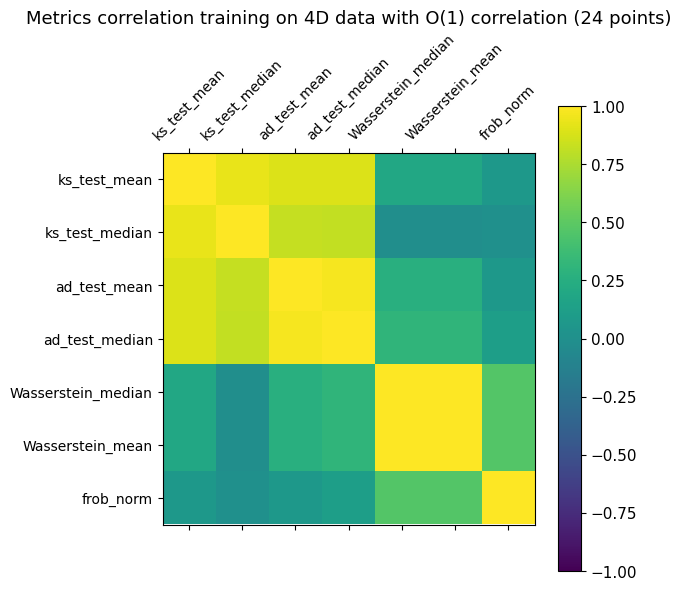

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,1.000000,0.967042,0.926768,0.965101,0.797419,0.797419,0.647274
ks_test_median,0.967042,1.000000,0.960458,0.939511,0.808451,0.808451,0.635820
ad_test_mean,0.926768,0.960458,1.000000,0.954362,0.787817,0.787817,0.582116
ad_test_median,0.965101,0.939511,0.954362,1.000000,0.802978,0.802978,0.584788
Wasserstein_median,0.797419,0.808451,0.787817,0.802978,1.000000,1.000000,0.694412
Wasserstein_mean,0.797419,0.808451,0.787817,0.802978,1.000000,1.000000,0.694412
frob_norm,0.647274,0.635820,0.582116,0.584788,0.694412,0.694412,1.000000


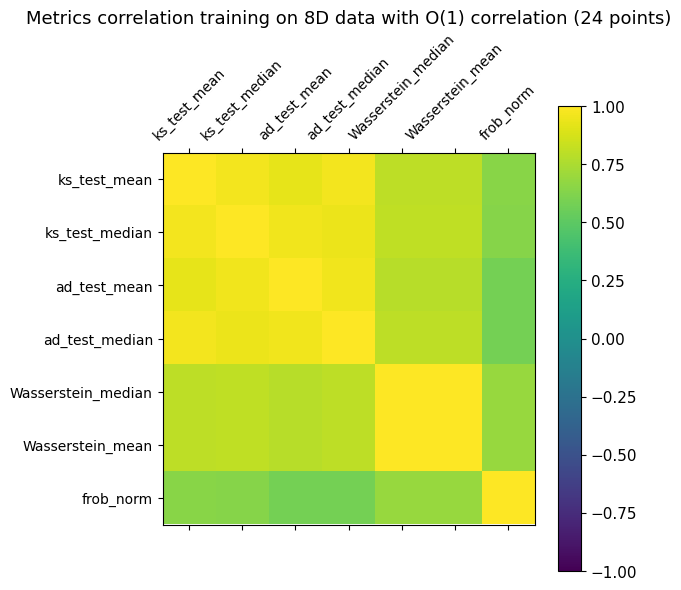

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,1.000000,0.966297,0.914251,0.984522,0.868532,0.868532,0.192691
ks_test_median,0.966297,1.000000,0.947428,0.938394,0.851045,0.851045,0.199939
ad_test_mean,0.914251,0.947428,1.000000,0.926429,0.824539,0.824539,0.229643
ad_test_median,0.984522,0.938394,0.926429,1.000000,0.842060,0.842060,0.176475
Wasserstein_median,0.868532,0.851045,0.824539,0.842060,1.000000,1.000000,0.364276
Wasserstein_mean,0.868532,0.851045,0.824539,0.842060,1.000000,1.000000,0.364276
frob_norm,0.192691,0.199939,0.229643,0.176475,0.364276,0.364276,1.000000


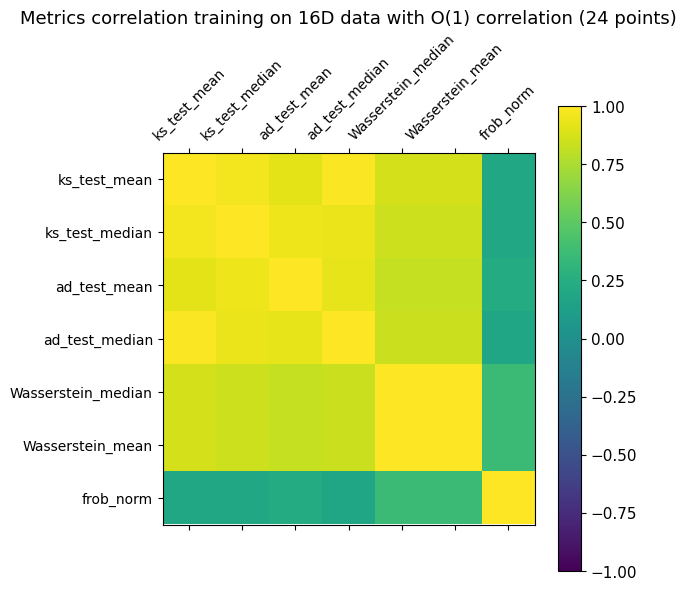

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,1.000000,0.986580,0.952716,0.994351,0.880500,0.880500,0.870477
ks_test_median,0.986580,1.000000,0.951057,0.975736,0.884383,0.884383,0.862394
ad_test_mean,0.952716,0.951057,1.000000,0.962211,0.858202,0.858202,0.840239
ad_test_median,0.994351,0.975736,0.962211,1.000000,0.875400,0.875400,0.860251
Wasserstein_median,0.880500,0.884383,0.858202,0.875400,1.000000,1.000000,0.852439
Wasserstein_mean,0.880500,0.884383,0.858202,0.875400,1.000000,1.000000,0.852439
frob_norm,0.870477,0.862394,0.840239,0.860251,0.852439,0.852439,1.000000


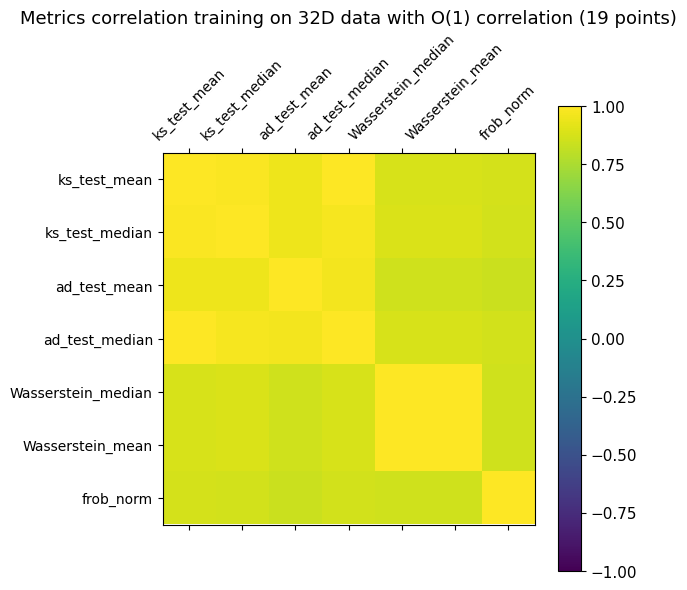

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,1.000000,0.990564,0.955163,0.988625,0.729246,0.729246,0.726287
ks_test_median,0.990564,1.000000,0.974019,0.986361,0.763450,0.763450,0.760295
ad_test_mean,0.955163,0.974019,1.000000,0.983113,0.881883,0.881883,0.879950
ad_test_median,0.988625,0.986361,0.983113,1.000000,0.818868,0.818868,0.816453
Wasserstein_median,0.729246,0.763450,0.881883,0.818868,1.000000,1.000000,0.999882
Wasserstein_mean,0.729246,0.763450,0.881883,0.818868,1.000000,1.000000,0.999882
frob_norm,0.726287,0.760295,0.879950,0.816453,0.999882,0.999882,1.000000


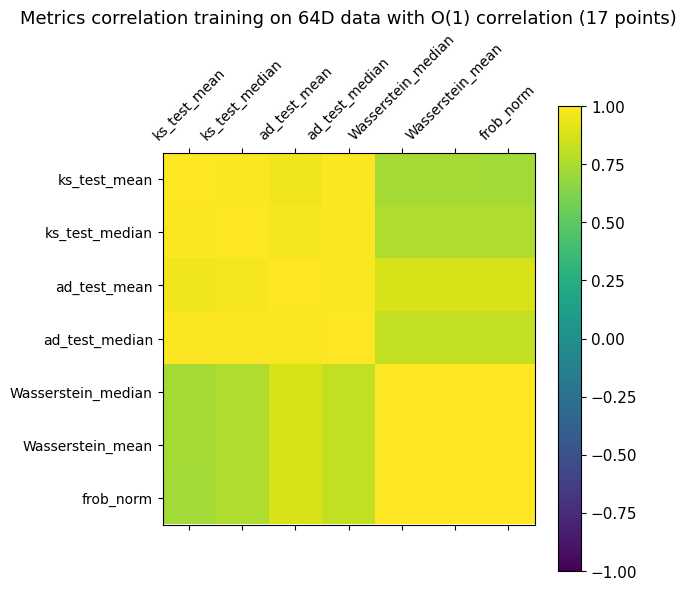

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,1.000000,0.965666,0.930448,0.997770,0.781943,0.781943,0.376114
ks_test_median,0.965666,1.000000,0.990213,0.969991,0.875707,0.875707,0.484686
ad_test_mean,0.930448,0.990213,1.000000,0.939460,0.900324,0.900324,0.509340
ad_test_median,0.997770,0.969991,0.939460,1.000000,0.785143,0.785143,0.403099
Wasserstein_median,0.781943,0.875707,0.900324,0.785143,1.000000,1.000000,0.582790
Wasserstein_mean,0.781943,0.875707,0.900324,0.785143,1.000000,1.000000,0.582790
frob_norm,0.376114,0.484686,0.509340,0.403099,0.582790,0.582790,1.000000


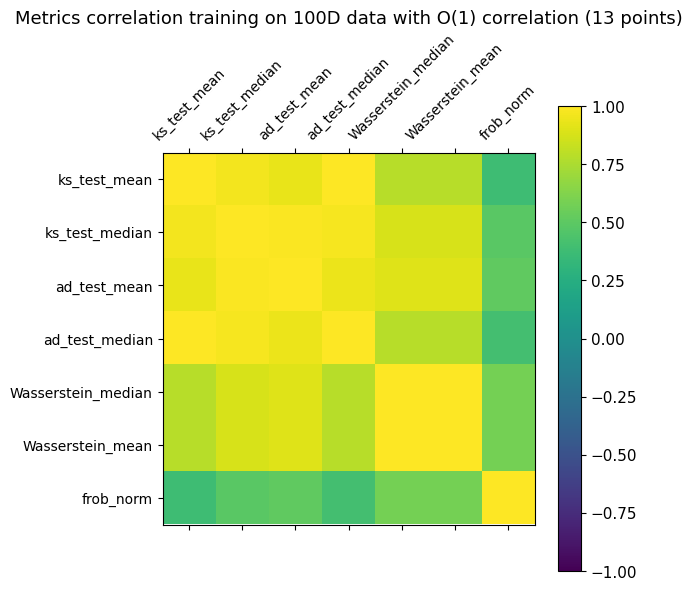

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,1.000000,0.995215,0.974545,0.991457,0.799471,0.799471,0.900859
ks_test_median,0.995215,1.000000,0.985999,0.988902,0.783032,0.783032,0.891973
ad_test_mean,0.974545,0.985999,1.000000,0.989082,0.826171,0.826171,0.919859
ad_test_median,0.991457,0.988902,0.989082,1.000000,0.845750,0.845750,0.931919
Wasserstein_median,0.799471,0.783032,0.826171,0.845750,1.000000,1.000000,0.976062
Wasserstein_mean,0.799471,0.783032,0.826171,0.845750,1.000000,1.000000,0.976062
frob_norm,0.900859,0.891973,0.919859,0.931919,0.976062,0.976062,1.000000


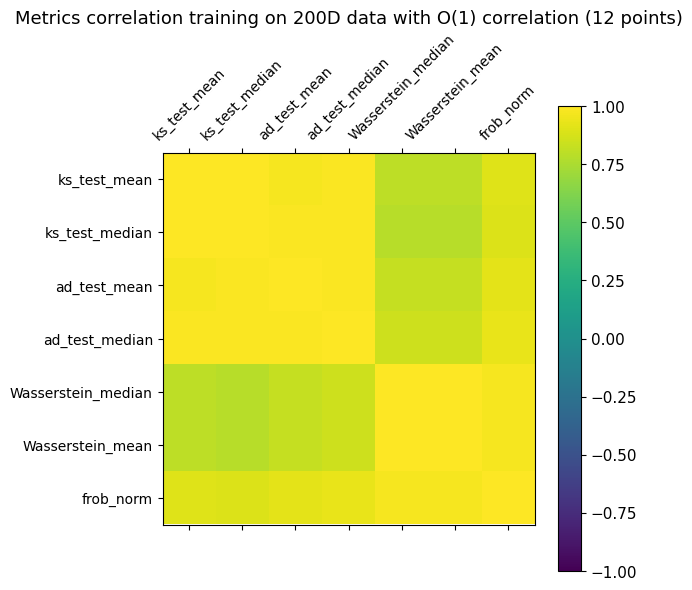

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,1.000000,0.998551,0.994413,0.997954,0.911533,0.911533,0.853771
ks_test_median,0.998551,1.000000,0.995077,0.995517,0.904659,0.904659,0.834647
ad_test_mean,0.994413,0.995077,1.000000,0.996766,0.925186,0.925186,0.816933
ad_test_median,0.997954,0.995517,0.996766,1.000000,0.931890,0.931890,0.842658
Wasserstein_median,0.911533,0.904659,0.925186,0.931890,1.000000,1.000000,0.719040
Wasserstein_mean,0.911533,0.904659,0.925186,0.931890,1.000000,1.000000,0.719040
frob_norm,0.853771,0.834647,0.816933,0.842658,0.719040,0.719040,1.000000


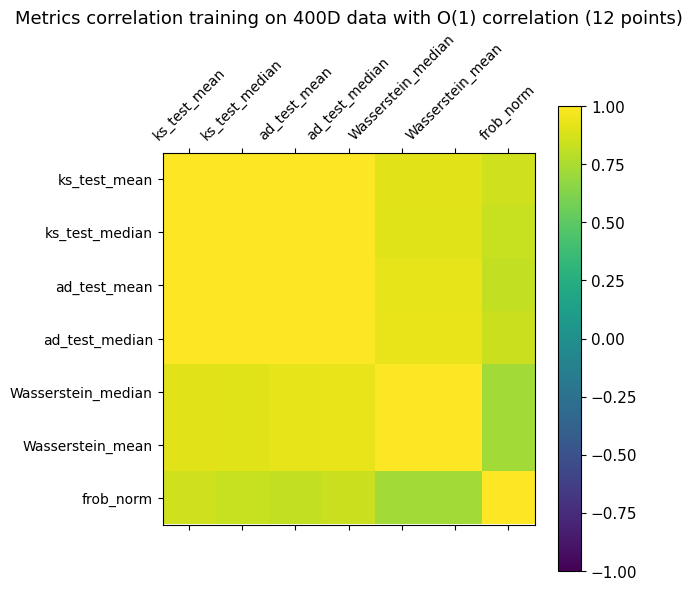

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,1.000000,0.997514,0.994725,0.995449,0.827751,0.827751,0.797056
ks_test_median,0.997514,1.000000,0.994265,0.990085,0.803979,0.803979,0.769608
ad_test_mean,0.994725,0.994265,1.000000,0.997032,0.837510,0.837510,0.807400
ad_test_median,0.995449,0.990085,0.997032,1.000000,0.862240,0.862240,0.836618
Wasserstein_median,0.827751,0.803979,0.837510,0.862240,1.000000,1.000000,0.976328
Wasserstein_mean,0.827751,0.803979,0.837510,0.862240,1.000000,1.000000,0.976328
frob_norm,0.797056,0.769608,0.807400,0.836618,0.976328,0.976328,1.000000


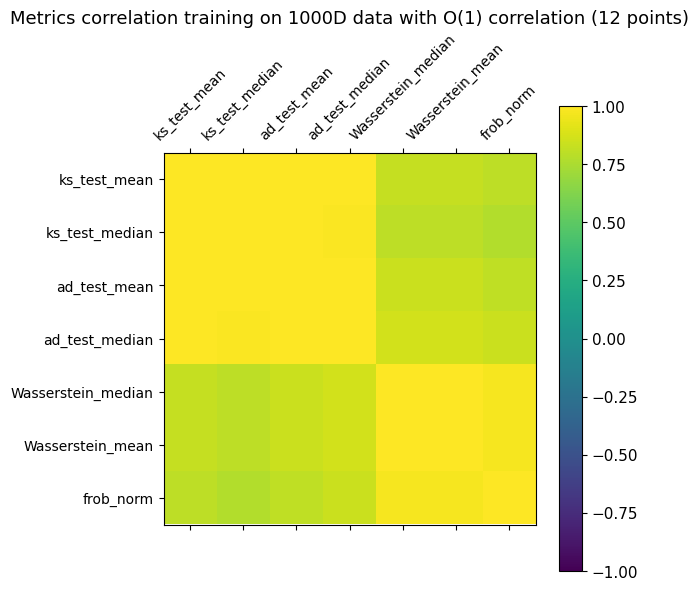

In [19]:
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "150%"),
                   ("color", 'lime')])]
metrics = ["ks_test_mean", "ks_test_median","ad_test_mean", "ad_test_median","Wasserstein_median", "Wasserstein_mean","frob_norm"]
for d in [4,8,16,32,64,100,200,400,1000]:
    df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]
    df=df.astype(float)
    n_points=len(df)
    df['Wasserstein_median'] = df['Wasserstein_median'].apply(lambda x: -x)
    df['Wasserstein_mean'] = df['Wasserstein_mean'].apply(lambda x: -x)
    df['frob_norm'] = df['frob_norm'].apply(lambda x: -x)
    #display(df)
    title = "Metrics correlation training on "+str(d)+"D data with O(1) correlation ("+str(n_points)+" points)"
    corr=df.corr()
    display(corr.style.set_caption(title).set_table_styles(styles))
    jtplot.reset()
    f = plt.figure(figsize=(6, 6))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=11)
    plt.clim(-1, 1) 
    plt.title(title, fontsize=13)
    plt.show()
    plt.close()
    del(df)

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,nan,nan,nan,nan,nan,nan,nan
ks_test_median,nan,nan,nan,nan,nan,nan,nan
ad_test_mean,nan,nan,nan,nan,nan,nan,nan
ad_test_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_mean,nan,nan,nan,nan,nan,nan,nan
frob_norm,nan,nan,nan,nan,nan,nan,nan


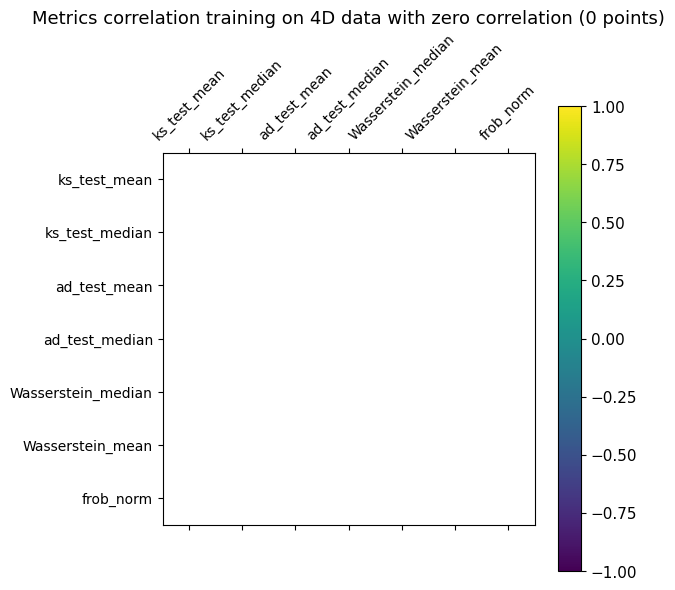

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,nan,nan,nan,nan,nan,nan,nan
ks_test_median,nan,nan,nan,nan,nan,nan,nan
ad_test_mean,nan,nan,nan,nan,nan,nan,nan
ad_test_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_mean,nan,nan,nan,nan,nan,nan,nan
frob_norm,nan,nan,nan,nan,nan,nan,nan


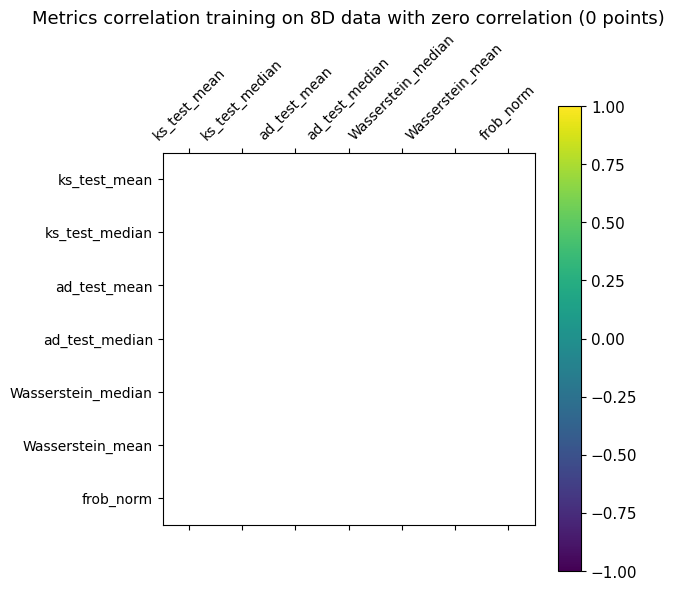

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,nan,nan,nan,nan,nan,nan,nan
ks_test_median,nan,nan,nan,nan,nan,nan,nan
ad_test_mean,nan,nan,nan,nan,nan,nan,nan
ad_test_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_mean,nan,nan,nan,nan,nan,nan,nan
frob_norm,nan,nan,nan,nan,nan,nan,nan


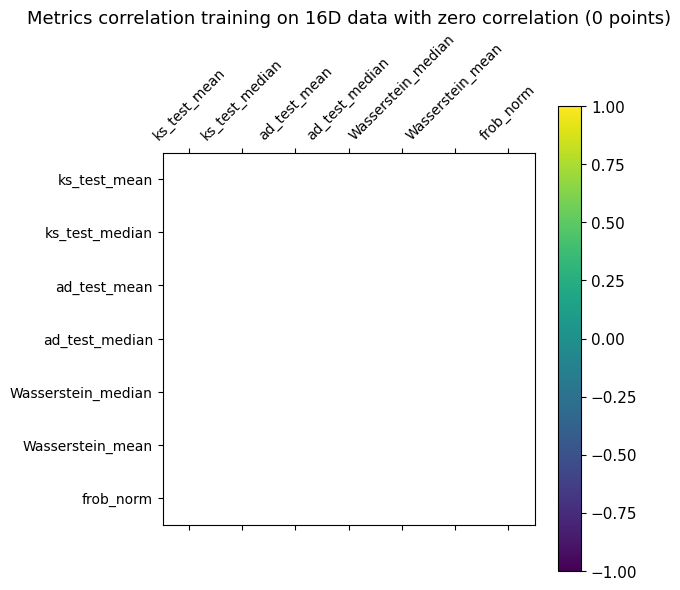

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,nan,nan,nan,nan,nan,nan,nan
ks_test_median,nan,nan,nan,nan,nan,nan,nan
ad_test_mean,nan,nan,nan,nan,nan,nan,nan
ad_test_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_mean,nan,nan,nan,nan,nan,nan,nan
frob_norm,nan,nan,nan,nan,nan,nan,nan


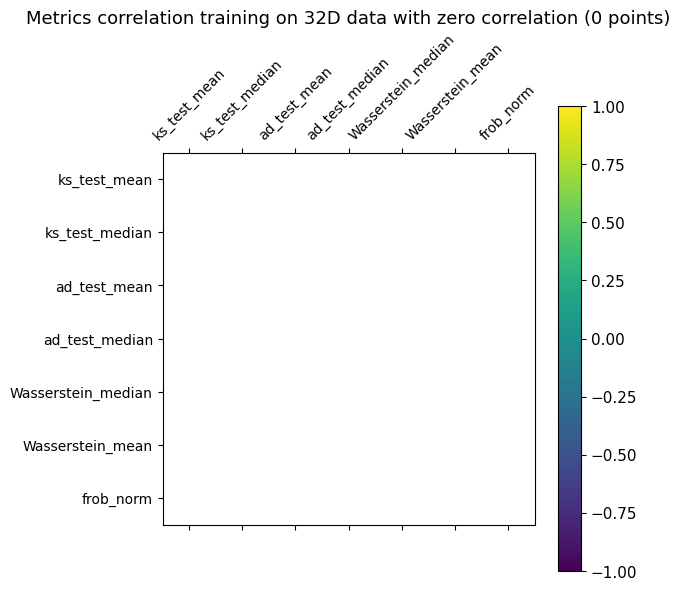

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,nan,nan,nan,nan,nan,nan,nan
ks_test_median,nan,nan,nan,nan,nan,nan,nan
ad_test_mean,nan,nan,nan,nan,nan,nan,nan
ad_test_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_mean,nan,nan,nan,nan,nan,nan,nan
frob_norm,nan,nan,nan,nan,nan,nan,nan


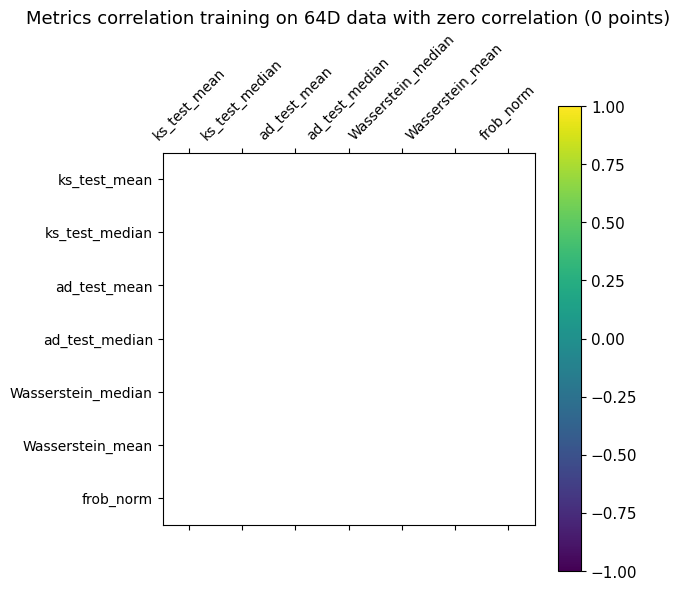

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,nan,nan,nan,nan,nan,nan,nan
ks_test_median,nan,nan,nan,nan,nan,nan,nan
ad_test_mean,nan,nan,nan,nan,nan,nan,nan
ad_test_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_mean,nan,nan,nan,nan,nan,nan,nan
frob_norm,nan,nan,nan,nan,nan,nan,nan


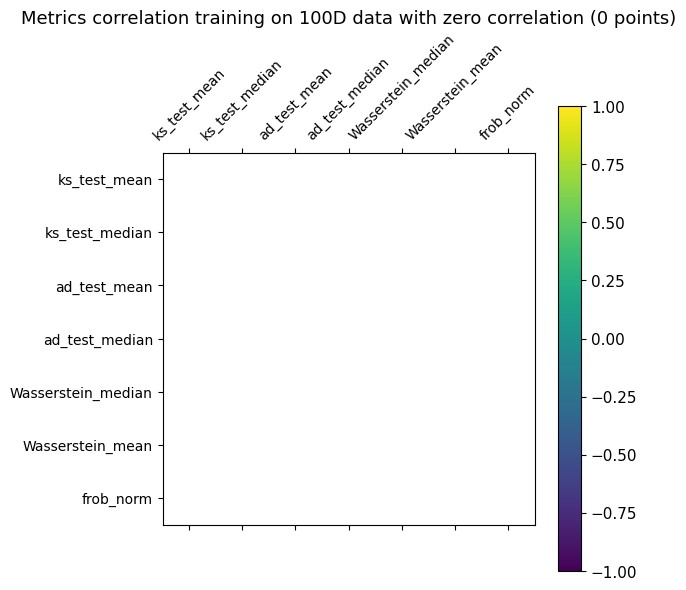

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,nan,nan,nan,nan,nan,nan,nan
ks_test_median,nan,nan,nan,nan,nan,nan,nan
ad_test_mean,nan,nan,nan,nan,nan,nan,nan
ad_test_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_mean,nan,nan,nan,nan,nan,nan,nan
frob_norm,nan,nan,nan,nan,nan,nan,nan


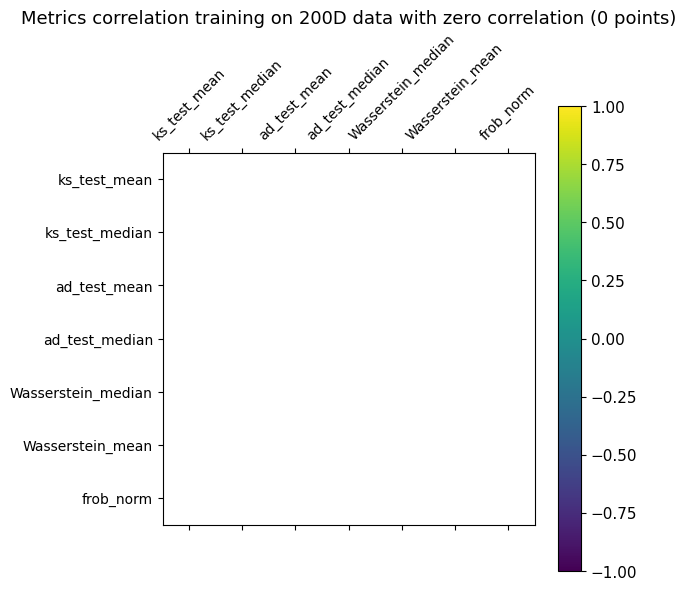

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,nan,nan,nan,nan,nan,nan,nan
ks_test_median,nan,nan,nan,nan,nan,nan,nan
ad_test_mean,nan,nan,nan,nan,nan,nan,nan
ad_test_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_mean,nan,nan,nan,nan,nan,nan,nan
frob_norm,nan,nan,nan,nan,nan,nan,nan


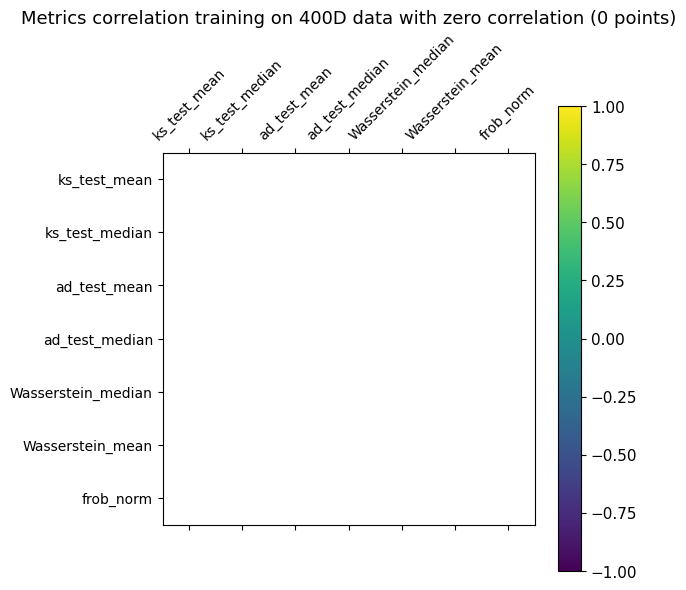

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,Wasserstein_median,Wasserstein_mean,frob_norm
ks_test_mean,nan,nan,nan,nan,nan,nan,nan
ks_test_median,nan,nan,nan,nan,nan,nan,nan
ad_test_mean,nan,nan,nan,nan,nan,nan,nan
ad_test_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_median,nan,nan,nan,nan,nan,nan,nan
Wasserstein_mean,nan,nan,nan,nan,nan,nan,nan
frob_norm,nan,nan,nan,nan,nan,nan,nan


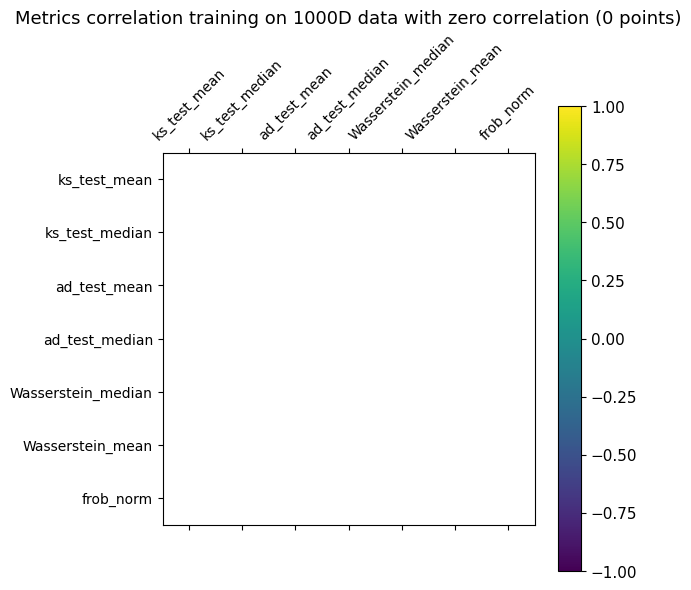

In [20]:
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "150%"),
                   ("color", 'lime')])]
metrics = ["ks_test_mean", "ks_test_median","ad_test_mean", "ad_test_median","Wasserstein_median", "Wasserstein_mean","frob_norm"]
for d in [4,8,16,32,64,100,200,400,1000]:
    df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]
    df=df.astype(float)
    n_points=len(df)
    df['Wasserstein_median'] = df['Wasserstein_median'].apply(lambda x: -x)
    df['Wasserstein_mean'] = df['Wasserstein_mean'].apply(lambda x: -x)
    df['frob_norm'] = df['frob_norm'].apply(lambda x: -x)
    #display(df)
    title = "Metrics correlation training on "+str(d)+"D data with zero correlation ("+str(n_points)+" points)"
    corr=df.corr()
    display(corr.style.set_caption(title).set_table_styles(styles))
    jtplot.reset()
    f = plt.figure(figsize=(6, 6))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=11)
    plt.clim(-1, 1) 
    plt.title(title, fontsize=13)
    plt.show()
    plt.close()
    del(df)

## Results for different dimensions and metrics

In [17]:
ascending=True
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)
df_reduced_sorted = {}
df_reduced_unc = {}
df_best_corr = {}
ndims_list = [4,8,16,32,64,100,200,400,1000]
sort_metrics_list = ["swd_mean","ks_mean"]
for sort_metric in sort_metrics_list:
    print("Processing",sort_metric,"metric")
    df_reduced_sorted[sort_metric] = {}
    df_reduced_unc[sort_metric] = {}
    df_best_corr[sort_metric] = {}
    for ndims in ndims_list:
        print("... in",ndims,"D")
        df_reduced = df_correlated[df_correlated["ndims"]==ndims]
        #df_reduced.pop("Wasserstein_median")
        #df_reduced.pop("Wasserstein_mean")
        df_reduced_unc[sort_metric][ndims] = df_correlated_unc[df_correlated_unc["ndims"]==ndims]
        #df_reduced_unc[sort_metric][ndims].pop("Wasserstein_median")
        #df_reduced_unc[sort_metric][ndims].pop("Wasserstein_mean")
        df_reduced[sort_metric] = df_reduced[sort_metric].astype(float)
        df_reduced_sorted[sort_metric][ndims] = df_reduced.sort_values(by=sort_metric,axis=0,ascending=ascending).reset_index(drop=True)
        #left_aligned_df = df_reduced_sorted.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
        #display(left_aligned_df)
        bests = []
        df = df_reduced_sorted[sort_metric][ndims]
        df_unc = df_reduced_unc[sort_metric][ndims]
        for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
            tmp_best=df[df["bijector"]==bijector][df["correlation"]=="corr"].drop_duplicates('bijector')
            tmp_best["nruns"] = int(len(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric]))
            tmp_best[sort_metric+"_mean"] = np.mean(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric])
            tmp_best[sort_metric+"_std"] = np.std(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric])
            bests.append(tmp_best)
        df_best=pd.concat(bests).sort_values(by=sort_metric,axis=0,ascending=ascending)
        column_to_move = df_best.pop(sort_metric+"_mean")
        pos_to_move = df_best.columns.get_loc(sort_metric)+2
        df_best.insert(pos_to_move, sort_metric+"_mean", column_to_move)
        column_to_move = df_best.pop(sort_metric+"_std")
        pos_to_move = pos_to_move+1
        df_best.insert(pos_to_move, sort_metric+"_std", column_to_move)
        column_to_move = df_best.pop("nruns")
        pos_to_move = pos_to_move+1
        df_best.insert(pos_to_move, "nruns", column_to_move)
        #df_best.pop("Wasserstein_median")
        #df_best.pop("Wasserstein_mean")
        df_best_corr[sort_metric][ndims] = df_best
        #left_aligned_df = df_best.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
        ##display(left_aligned_df)

Processing swd_mean metric
... in 4 D
... in 8 D
... in 16 D
... in 32 D
... in 64 D
... in 100 D
... in 200 D


/tmp/ipykernel_7004/563619531.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced[sort_metric] = df_reduced[sort_metric].astype(float)
/tmp/ipykernel_7004/563619531.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best=df[df["bijector"]==bijector][df["correlation"]=="corr"].drop_duplicates('bijector')
/tmp/ipykernel_7004/563619531.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best["nruns"] = int(len(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric]))
/tmp/ipykernel_7004/563619531.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best[sort_metric+"_mean"] = np.mean(df_unc[df_unc["bijec

... in 400 D
... in 1000 D
Processing ks_mean metric
... in 4 D
... in 8 D
... in 16 D
... in 32 D
... in 64 D
... in 100 D
... in 200 D
... in 400 D
... in 1000 D


/tmp/ipykernel_7004/563619531.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best=df[df["bijector"]==bijector][df["correlation"]=="corr"].drop_duplicates('bijector')
/tmp/ipykernel_7004/563619531.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best["nruns"] = int(len(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric]))
/tmp/ipykernel_7004/563619531.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best[sort_metric+"_mean"] = np.mean(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric])
/tmp/ipykernel_7004/563619531.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best[sort_metric+"_std"] = np.std(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric])
/tmp/ipykernel_7004/563619531.py:30: UserWarning: Boolean Series key will be reindexed to matc

In [26]:
sort_metrics_list = ["sliced_Wasserstein_mean","ks_test_median"]

In [ ]:
df_reduced.sort_values(by=sort_metric,axis=0,ascending=ascending).reset_index(drop=True)

In [19]:
ndims=4
sort_metric="swd_mean"
#sort_metric="run_n"
ascending=True
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_tmp = df_reduced_sorted["swd_mean"][ndims]
df_tmp = df_tmp[df_tmp["bijector"]=="MAFN"]
left_aligned_df = df_tmp.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
display(left_aligned_df)

,run_n,run_seed,ndims,nsamples,correlation,nbijectors,bijector,activation,spline_knots,range_min,eps_regulariser,regulariser,ks_mean,ks_std,ad_mean,ad_std,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std,hidden_layers,batch_size,epochs_input,epochs_output,time
9,1,0,4,100000,corr,5,MAFN,relu,8,-5,0,None,0.479285,0.295250,0.210818,0.072579,0.079048,0.033835,0.077915,0.038284,0.086389,0.049542,128-128-128,512,1000,323,745.240984
15,2,0,4,100000,corr,5,MAFN,relu,8,-5,0,None,0.504421,0.284632,0.221983,0.059968,0.079995,0.033329,0.079717,0.039971,0.087743,0.040154,256-256-256,512,1000,361,833.398603
16,3,0,4,100000,corr,10,MAFN,relu,8,-5,0,None,0.510273,0.288716,0.218617,0.063455,0.080910,0.036001,0.080013,0.041611,0.086235,0.046316,128-128-128,512,1000,288,1834.018883
23,4,0,4,100000,corr,10,MAFN,relu,8,-5,0,None,0.442665,0.295300,0.194875,0.082358,0.092215,0.043582,0.089042,0.050943,0.104770,0.063823,256-256-256,512,1000,202,901.423236


In [20]:
df_result=pd.DataFrame()
sort_metric="swd_mean"
#sort_metric="ks_test_median"
ascending=True
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
for i in [1,2,3,4]:
    tmp = recompute_metrics(run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(i)+"/results.txt")
    df_result= pd.concat([df_result,tmp])
#left_aligned_df = df_result.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
#display(left_aligned_df)
display(df_result)

Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


[0.032620666980743424, 0.08291252446174621, 0.03772835922241212, 0.07791515874862671, 0.09659262466430668, 0.08506637370586395, 0.11112226283550264, 0.06967371964454651, 0.08844845032691957, 0.07061071288585663, 0.061942330479621874, 0.05440192317962647, 0.13789797782897956, 0.0615240124464035, 0.12085604238510131, 0.1472591242790222, 0.04459415507316592, 0.07707343077659608, 0.06338093721866608, 0.1000870268344879, 0.1322427949905396, 0.06795618712902068, 0.09049561190605165, 0.11514270281791686, 0.11472248601913455, 0.10885986888408661, 0.13339121103286747, 0.166237583398819, 0.07167986631393435, 0.06777105534076691, 0.05760729455947875, 0.12608986020088192, 0.029191527843475337, 0.05032698392868043, 0.056645456671714785, 0.07525036120414734, 0.03149152326583862, 0.07271340143680573, 0.058081361770629905, 0.06726170492172243, 0.07222702217102056, 0.06305700075626375, 0.03853258061408997, 0.06715877389907837, 0.053063489913940456, 0.05526920711994171, 0.04710677564144132, 0.0566781890

Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ computed and saved in 4.713712382999802 s.
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


[0.02426959609985352, 0.08521134078502654, 0.0375806188583374, 0.04759635090827942, 0.08023498439788823, 0.10543845438957214, 0.09252638709545136, 0.04976093578338623, 0.05157515597343447, 0.04465098333358765, 0.06484540307521817, 0.1039182949066162, 0.10743408203125003, 0.06886213552951813, 0.1087994966506958, 0.13745757913589476, 0.13068413949012764, 0.06885531878471375, 0.10534445154666904, 0.06973235297203065, 0.08781284856796266, 0.07848672783374787, 0.07744397890567782, 0.05140275526046753, 0.1368190016746522, 0.1537306374311447, 0.12755724287033082, 0.11323706626892091, 0.05736135196685792, 0.06354318797588349, 0.04858595609664916, 0.09589393663406373, 0.06692949104309087, 0.0496702516078949, 0.06794630372524263, 0.09963168478012085, 0.04279931688308718, 0.050547838091850275, 0.06617201554775239, 0.06777258253097534, 0.05984793710708622, 0.0796239857673645, 0.040749623298645024, 0.09819641327857971, 0.06959396457672122, 0.054743515491485595, 0.04474975979328154, 0.10042689561843

Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_2/ computed and saved in 4.534904878999441 s.
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


[0.03428236150741577, 0.09879018580913543, 0.044630856990814205, 0.07124893999099732, 0.03421151614189148, 0.06417658686637878, 0.041028617978096024, 0.05426878976821901, 0.07112717652320866, 0.06863100922107697, 0.07959072303771972, 0.11866891527175902, 0.16550657320022588, 0.14744054901599887, 0.08749171900749207, 0.07958699178695677, 0.03373907494544982, 0.03693062806129456, 0.041589777827262885, 0.061862050771713264, 0.09019029045104984, 0.08271823048591614, 0.0854016206264496, 0.10915346455574033, 0.0980944976806641, 0.06437270963191986, 0.0788124022483826, 0.0993355815410614, 0.032741900444030775, 0.11109494566917419, 0.049410174608230606, 0.06435254645347596, 0.02905901098251344, 0.04991193926334381, 0.06822290360927581, 0.06819963741302489, 0.09382406616210935, 0.07169520926475526, 0.09494831001758577, 0.07806019067764283, 0.08235893154144291, 0.10917339134216308, 0.037048733234405516, 0.06309935903549194, 0.14272347807884223, 0.10510761070251465, 0.13190175998210907, 0.1303998

Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_3/ computed and saved in 4.539971554000658 s.
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


[0.15708366656303413, 0.14624964046478273, 0.09298794889450077, 0.1008891007900238, 0.18204994487762458, 0.12786482465267182, 0.1195054055452347, 0.09900251030921936, 0.07083538174629217, 0.07794062614440919, 0.06682503914833068, 0.06839861249923707, 0.23080104255676281, 0.10936010324954987, 0.14469353961944584, 0.11897560620307922, 0.04743997812271118, 0.04806621128320694, 0.0387535446882248, 0.07233480715751647, 0.11269126510620123, 0.07449663031101228, 0.10316711950302127, 0.07786449646949767, 0.04790927696228029, 0.049157826066017166, 0.052010183334350577, 0.15652277541160584, 0.13244510245323188, 0.15063042151927947, 0.09526225352287296, 0.09271170473098755, 0.03655208683013916, 0.07799355387687684, 0.056149321913719186, 0.06674001002311707, 0.11589897537231436, 0.09425328946113586, 0.1153666309118271, 0.09952529597282411, 0.19758571839332595, 0.15121927106380462, 0.11536399507522588, 0.07281002879142762, 0.0470384273529053, 0.08795888864994048, 0.07815108740329743, 0.049536518335

Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_4/ computed and saved in 4.725101668000207 s.


,run_n,run_seed,ndims,nsamples,correlation,nbijectors,bijector,activation,spline_knots,range_min,eps_regulariser,regulariser,ks_mean,ks_std,ad_mean,ad_std,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std,hidden_layers,batch_size,epochs_input,epochs_output,time
0,1,0,4,100000,corr,5,MAFN,relu,8,-5,0,None,0.479285,0.295250,0.210818,0.072579,0.079048,0.033835,0.077915,0.038284,0.086389,0.049542,128-128-128,512,1000,323,745.240984
0,2,0,4,100000,corr,5,MAFN,relu,8,-5,0,None,0.504421,0.284632,0.221983,0.059968,0.079995,0.033329,0.079717,0.039971,0.087743,0.040154,256-256-256,512,1000,361,833.398603
0,3,0,4,100000,corr,10,MAFN,relu,8,-5,0,None,0.510273,0.288716,0.218617,0.063455,0.080910,0.036001,0.080013,0.041611,0.086235,0.046316,128-128-128,512,1000,288,1834.018883
0,4,0,4,100000,corr,10,MAFN,relu,8,-5,0,None,0.442665,0.295300,0.194875,0.082358,0.092215,0.043582,0.089042,0.050943,0.104770,0.063823,256-256-256,512,1000,202,901.423236


In [101]:
from scipy.stats import wasserstein_distance
def Wasserstein_distance_old(target_test_data,nf_dist,norm=True):
    print("\nWasserstein_distance_old function")
    ##create data sample from trained normising flow
    #z=base_dist.sample((target_test_data.shape[0]))
    #x_estimated=nf_dist.bijector.forward(z).numpy()
    if norm==False:
        x_estimated=nf_dist.sample(target_test_data.shape[0])
        x_estimated=np.reshape(x_estimated,newshape=target_test_data.shape)
    else:
        x_estimated=nf_dist
    wasserstein_distances=[]
    for dim in range(target_test_data.shape[1]):
        #print(wasserstein_distance(x_target[:,dim], x_estimated[:,dim]))
        ws_distance=wasserstein_distance(target_test_data[:,dim], x_estimated[:,dim])
        wasserstein_distances.append(ws_distance)
    wd_mean = np.mean(wasserstein_distances)
    wd_std = np.std(wasserstein_distances)
    print(len(wasserstein_distances),"WD tests performed with",[len(target_test_data),len(x_estimated)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wasserstein_distances)
    return [wd_mean,wd_std]

def sliced_Wasserstein_distance_old(target_test_data, nf_dist, norm=True, n_slices=None, seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    """
    print("\nsliced_Wasserstein_distance_old function")
    if seed is None:
        np.random.seed(np.random.randint(10e6))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = target_test_data.shape[1]
    else:
        n_slices = int(n_slices)
    if norm==False:
        x_estimated=nf_dist.sample(target_test_data.shape[0])
        x_estimated=np.reshape(x_estimated,newshape=target_test_data.shape)
    else:
        x_estimated=nf_dist
    # Generate random directions
    directions = np.random.randn(n_slices, target_test_data.shape[1])
    directions /= np.linalg.norm(directions, axis=1)[:, None]
    # Compute sliced Wasserstein distance
    ws_distances = []
    for direction in directions:
        target_proj = target_test_data @ direction
        estimated_proj = x_estimated @ direction
        ws_distances.append(wasserstein_distance(target_proj, estimated_proj))
    swd_mean = np.mean(ws_distances)
    swd_std = np.std(ws_distances)
    print(len(ws_distances),"SWD tests performed with",[len(target_test_data),len(x_estimated)],"dimensional samples.")
    print("SWD Mean =",swd_mean)
    print("SWD Std =",swd_std)
    #print("Samples =\n",wasserstein_distances)
    return [swd_mean,swd_std]

def WD(dist_1,dist_2,n_iter=100,batch_size=100000):
    """
    The Wasserstein distance between the target distribution and the distribution of the test data.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nWD function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ad_list that will contain the list of wd for all dimensions and all iterations
    wd_list=[]
    # Loop over all iterations
    for k in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_k=dist_1[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_k=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        if isinstance(dist_2, np.ndarray):
            dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_2, tfd.distribution.Distribution):
            dist_2_k=dist_2.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        # The WD test is computed and saved for each dimension
        for dim in range(ndims):
            wd=wasserstein_distance(dist_1_k[:,dim], dist_2_k[:,dim])
            wd_list.append(wd)
    #print(wd_list)
    # Compute the mean and std of the p-values
    wd_mean = np.mean(wd_list)
    wd_std = np.std(wd_list)
    print(len(wd_list),"WD tests performed with",[len(dist_1_k),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wd_list)
    # Return the mean and std of the p-values
    #return wd_list
    return [wd_mean,wd_std]

def SWD(dist_1,dist_2,n_iter=100,batch_size=100000,n_slices=100,seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nSWD function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    if seed is None:
        np.random.seed(np.random.randint(1000000))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = np.max([100,ndims])
    else:
        n_slices = int(n_slices)
    # Define ad_list that will contain the list of swd for all dimensions and all iterations
    swd_list=[]
    # Loop over all iterations
    for k in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_k=dist_1[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_k=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        if isinstance(dist_2, np.ndarray):
            dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_2, tfd.distribution.Distribution):
            dist_2_k=dist_2.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        # Generate random directions
        directions = np.random.randn(n_slices, ndims)
        directions /= np.linalg.norm(directions, axis=1)[:, None]
        # Compute sliced Wasserstein distance
        for direction in directions:
            dist_1_proj = dist_1_k @ direction
            dist_2_proj = dist_2_k @ direction
            swd_list.append(wasserstein_distance(dist_1_proj, dist_2_proj))
    # Compute the mean and std of the p-values
    swd_mean = np.mean(swd_list)
    swd_std = np.std(swd_list)
    print(len(swd_list),"WD tests performed with",[len(dist_1_k),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",swd_mean)
    print("WD Std =",swd_std)
    return [swd_mean,swd_std]
    
def WD_new(dist_1,dist_2,n_iter=100,batch_size=100000):
    """
    The Wasserstein distance between the target distribution and the distribution of the test data.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nWD_new function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    n_iter=int(np.ceil(np.sqrt(n_iter)))
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ad_list that will contain the list of wd for all dimensions and all iterations
    wd_list=[]
    # Loop over all iterations
    for j in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_j=dist_1[j*batch_size:(j+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_j=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        for k in range(n_iter):
            if isinstance(dist_2, np.ndarray):
                dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
            elif isinstance(dist_2, tfd.distribution.Distribution):
                dist_2_k=dist_2.sample(batch_size).numpy()
            else:   
                raise ValueError("dist_1 must be either a numpy array or a distribution")
            # The WD test is computed and saved for each dimension
            for dim in range(ndims):
                wd=wasserstein_distance(dist_1_j[:,dim], dist_2_k[:,dim])
                wd_list.append(wd)
    #print(wd_list)
    # Compute the mean and std of the p-values
    wd_mean = np.mean(wd_list)
    wd_std = np.std(wd_list)
    print(len(wd_list),"WD tests performed with",[len(dist_1_j),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wd_list)
    # Return the mean and std of the p-values
    #return wd_list
    return [wd_mean,wd_std]

def SWD_new(dist_1,dist_2,n_iter=100,batch_size=100000,n_slices=100,seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nSWD_new function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    n_iter=int(np.ceil(np.sqrt(n_iter)))
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    if seed is None:
        np.random.seed(np.random.randint(1000000))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = np.max([100,ndims])
    else:
        n_slices = int(n_slices)
    # Define ad_list that will contain the list of swd for all dimensions and all iterations
    swd_list=[]
    # Loop over all iterations
    for j in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_j=dist_1[j*batch_size:(j+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_j=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        for k in range(n_iter):
            if isinstance(dist_2, np.ndarray):
                dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
            elif isinstance(dist_2, tfd.distribution.Distribution):
                dist_2_k=dist_2.sample(batch_size).numpy()
            else:   
                raise ValueError("dist_1 must be either a numpy array or a distribution")
            # Generate random directions
            directions = np.random.randn(n_slices, ndims)
            directions /= np.linalg.norm(directions, axis=1)[:, None]
            # Compute sliced Wasserstein distance
            for direction in directions:
                dist_1_proj = dist_1_j @ direction
                dist_2_proj = dist_2_k @ direction
                swd_list.append(wasserstein_distance(dist_1_proj, dist_2_proj))
    # Compute the mean and std of the p-values
    swd_mean = np.mean(swd_list)
    swd_std = np.std(swd_list)
    print(len(swd_list),"WD tests performed with",[len(dist_1_j),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",swd_mean)
    print("WD Std =",swd_std)
    return [swd_mean,swd_std]

In [103]:
start=timer()
run_number=1
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=100
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 4

Wasserstein_distance_old function
4 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.02340137078166008
WD Std = 0.009209796194437259

sliced_Wasserstein_distance_old function
4 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.019519479100803552
SWD Std = 0.013283497840382134

WD function
400 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.07904838952064513
WD Std = 0.03383512246026681

SWD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.07764633586110947
WD Std = 0.03776875115714374

WD_new function
400 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.030263581353724
WD Std = 0.011879827727038328

SWD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.029726910266281624
WD Std = 0.013096652993534266
Done in 103.0855696380022 s.


In [104]:
start=timer()
run_number=9
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=100
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 16

Wasserstein_distance_old function
16 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.03373500612157289
WD Std = 0.020203493432553742

sliced_Wasserstein_distance_old function
16 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.03807984620331259
SWD Std = 0.01555921475824211

WD function
1600 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.06871675304284244
WD Std = 0.05109879416747633

SWD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.0755253201607247
WD Std = 0.04681886827398734

WD_new function
1600 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03671606686621906
WD Std = 0.024448967631089943

SWD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03922254648166329
WD Std = 0.020919553847710236
Done in 124.16610923800908 s.


In [106]:
start=timer()
run_number=9
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=10
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 16

Wasserstein_distance_old function
16 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.03373500612157289
WD Std = 0.020203493432553742

sliced_Wasserstein_distance_old function
16 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.03807984620331259
SWD Std = 0.01555921475824211

WD function
160 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03671606686621905
WD Std = 0.024448967631089943

SWD function
1000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.0390375798340183
WD Std = 0.020759058955144655

WD_new function
256 WD tests performed with [25000, 25000] dimensional samples.
WD Mean = 0.03510304074570403
WD Std = 0.024569943344250545

SWD_new function
1600 WD tests performed with [25000, 25000] dimensional samples.
WD Mean = 0.03734863271674013
WD Std = 0.020646115816772684
Done in 59.059644709006534 s.


In [105]:
start=timer()
run_number=21
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=100
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 100

Wasserstein_distance_old function
100 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.12023903130116201
WD Std = 0.061544315592497505

sliced_Wasserstein_distance_old function
100 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.11960075962144863
SWD Std = 0.07316267405525886

WD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.14771710188628637
WD Std = 0.10798763503639176

SWD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.14280971260927397
WD Std = 0.11204016134380657

WD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.12117306563900083
WD Std = 0.06593168162435659

SWD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.11388370431228448
WD Std = 0.07391762004393752
Done in 210.4752859250002 s.


In [102]:
start=timer()
ndims=4
ncomp=3
ntest_samples=10000
seed_dist_1 = 0
seed_dist_2 = 1
seed_test_1 = 0
seed_test_2 = 1
n_iter=1000
batch_size=10000
targ_dist_1=MixtureGaussian1(ncomp,ndims,seed=seed_dist_1)
targ_dist_2=MixtureGaussian2(ncomp,ndims,seed=seed_dist_1)
X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test_1).numpy()
X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test_2).numpy()
print(KS_test(X_data_test_1,X_data_test_2,n_iter=n_iter,batch_size=batch_size))
#print(KS_test(targ_dist_1,X_data_test_2,n_iter=n_iter,batch_size=batch_size))
#print(KS_test(X_data_test_1,targ_dist_2,n_iter=n_iter,batch_size=batch_size))
print(KS_test(targ_dist_1,targ_dist_2,n_iter=n_iter,batch_size=batch_size))
end=timer()
print("Done in",end-start,"s.")

Computing KS for samples with lengths: 10
4000
[0.603388352746325, 0.31103815579226224]
Computing KS for samples with lengths: 10000
4000
[0.18471494566976424, 0.239360746698701]
Done in 105.119051691001 s.


In [88]:
targ_dist_1.components[]

ListWrapper([<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[4] dtype=float64>, <tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[4] dtype=float64>, <tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[4] dtype=float64>])

In [45]:
isinstance(targ_dist_1,np.ndarray)

False

In [42]:
isinstance(targ_dist_1,tfp.distributions.Distribution)
isinstance(targ_dist_1,np.ndarray)

False

In [40]:
k=0
n_iter=100
ndims=X_data_test.shape[1]
nsamples=X_data_test.shape[0]
batch_size=int(nsamples/n_iter)
batch_test=X_data_test[k*batch_size:(k+1)*batch_size,:]
x_estimated=X_data_nf[k*batch_size:(k+1)*batch_size,:]

nf_cov = np.cov(x_estimated,bias=True,rowvar=False)
nf_cov = np.tril(nf_cov)
nf_corr = correlation_from_covariance(nf_cov)

target_cov=np.cov(batch_test,bias=True,rowvar=False)
target_cov=np.tril(target_cov)
#target_corr=correlation_from_covariance(target_cov)

In [41]:
target_cov

array([[4.2423983, 0.       , 0.       , 0.       ],
       [9.567057 , 3.222494 , 0.       , 0.       ],
       [4.2666135, 5.7889166, 3.3957214, 0.       ],
       ...,
       [4.240755 , 6.9646473, 3.7654471, 8.934936 ],
       [4.226079 , 6.848956 , 3.5189347, 7.6689568],
       [4.2434874, 6.3121815, 3.9492416, 8.239237 ]], dtype=float32)

In [19]:
FN(X_data_test,X_data_nf)

ValueError: operands could not be broadcast together with shapes (1000,4) (4,4) 

In [18]:
res={}
for run_number in [1]:
#for run_number in [13,14,15,16]:
    run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    ncomp=3
    ntest_samples=100000
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    #targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    #targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    #X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    #X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    
    #for seed in np.random.randint(0,1000000,20):
    #    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=int(seed)).numpy().astype("float32")
    #    FN_n,_,_=Metrics.FrobNorm(X_data_test_1,X_data_nf)
    #    FN.append(FN_n)
    FN_val = FN(X_data_test,X_data_nf)
    SWD_val = Metrics.SWD(X_data_test,X_data_nf,n_slices=10,seed=np.random.randint(1000000))
    #for n in [10]:
    #    for seed in np.random.randint(0,1000000,10):     
    #        res_n = Metrics.sliced_Wasserstein_distance(X_data_test,X_data_nf,n_slices=n,seed=seed)
    #        #res_n = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=n,seed=seed)
    #        res.append(res_n)
    #        print(res_n)
    res[run_number]={"SWD":SWD,"FN":FN}
    print(res[run_number])

ValueError: operands could not be broadcast together with shapes (1000,4) (4,4) 

In [19]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    start=timer()
    ks_mean,ks_std,ad_mean,ad_std,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'ks_mean':[ks_mean],
                    'ks_std':[ks_std],
                    'ad_mean':[ad_mean],
                    'ad_std':[ad_std],
                    'wd_mean':[wd_mean],
                    'wd_std':[wd_std],
                    'swd_mean':[swd_mean],
                    'swd_std':[swd_std],
                    'fn_mean':[fn_mean],
                    'fn_std':[fn_std],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    #os.rename(run, run.replace(".txt","_old.txt"))
    #Utils.results_current(run.replace("results.txt",""),results_dict)
    tmp_new = pd.DataFrame(results_dict)
    #tmp_new = pd.read_csv(run)
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp_new

In [22]:
sort_metric="SWD_mean"
#sort_metric="ks_test_median"
ascending=True
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_result = recompute_metrics(run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/results.txt")
#left_aligned_df = df_result.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
display(df_result)

Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ computed and saved in 5.539433668000129 s.


,run_n,run_seed,ndims,nsamples,correlation,nbijectors,bijector,activation,spline_knots,range_min,eps_regulariser,regulariser,ks_mean,ks_std,ad_mean,ad_std,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std,hidden_layers,batch_size,epochs_input,epochs_output,time
0,1,0,4,100000,corr,5,MAFN,relu,8,-5,0,None,0.479285,0.29525,0.210818,0.072579,0.079048,0.033835,0.077915,0.038284,0.04263,2.081668e-17,128-128-128,512,1000,323,745.240984


In [290]:
SWD_list = []
for nsamples in [10000,100000,1000000]:
    ndims=4
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    SWD = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=100,seed=np.random.randint(1000000))
    SWD_list.append([nsamples,SWD])
    print([nsamples,SWD])

[10000, [0.03242777552842393, 0.01778819546447554]]
[100000, [0.011425536151111464, 0.004952796941549029]]
[1000000, [0.0022367948656308117, 0.0007193789769005433]]


In [291]:
SWD_list = []
for nsamples in [10000,100000,1000000]:
    ndims=4
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    SWD = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=1000,seed=np.random.randint(1000000))
    SWD_list.append([nsamples,SWD])
    print([nsamples,SWD])

[10000, [0.03468181361910674, 0.017766327001419276]]
[100000, [0.011701384946107625, 0.0052862062353391135]]
[1000000, [0.0022781766000493694, 0.0007203478363419516]]


ValueError: x and y must have same first dimension, but have shapes (3,) and (10,)

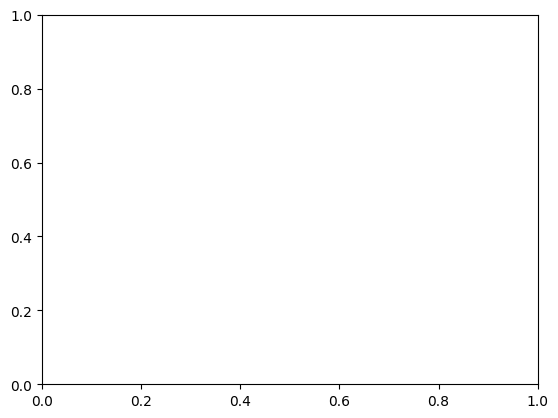

In [223]:
plt.figure(2)
plt.plot([10,100,1000], res[:,0], label="SWD")
plt.fill_between([10,100,1000], res[:,0] - 2 * res[:,1], res[:,0] + 2 * res[:,1], alpha=0.5)

plt.legend()
plt.xscale('log')

plt.xlabel("Number of projections")
plt.ylabel("Distance")
plt.title('Sliced Wasserstein Distance with 95% confidence inverval')

plt.show()

## Best models

In [141]:
df_bests_corr = list(df_best_corr["sliced_Wasserstein_mean"].values())

In [142]:
tmp=pd.concat(df_bests_corr)
tmp2=tmp[tmp["bijector"]=="MAFN"]
tmp2[tmp2["correlation"]=="corr"]

,run_n,run_seed,ndims,nsamples,correlation,nbijectors,bijector,activation,spline_knots,range_min,eps_regulariser,regulariser,kl_divergence,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,sliced_Wasserstein_mean,sliced_Wasserstein_std,sliced_Wasserstein_mean_mean,sliced_Wasserstein_mean_std,nruns,frob_norm,hidden_layers,batch_size,epochs_input,epochs_output,time
8,2,0,4,100000,corr,5,MAFN,relu,8,-5,0,None,-1,0.504421,0.518005,0.223863,0.221983,0.021769,0.007086,0.028155,0.007063,10,0.023668,256-256-256,512,1000,361,833.398603
1,7,0,8,100000,corr,10,MAFN,relu,8,-5,0,None,-1,0.471417,0.479054,0.218443,0.215214,0.025050,0.008638,0.030646,0.015187,9,0.048585,128-128-128,512,1000,296,1794.298420
1,10,0,16,100000,corr,5,MAFN,relu,8,-5,0,None,-1,0.488434,0.495043,0.215383,0.213272,0.025364,0.011847,0.029399,0.004381,5,0.548248,256-256-256,512,1000,326,914.736928
0,14,0,32,100000,corr,5,MAFN,relu,8,-5,0,None,-1,0.489698,0.492980,0.217061,0.215439,0.021386,0.008449,0.036246,0.010819,10,0.121839,256-256-256,512,1000,176,493.744012
2,17,0,64,100000,corr,5,MAFN,relu,8,-5,0,None,-1,0.476225,0.485904,0.213891,0.210892,0.034605,0.018001,0.056841,0.027705,10,0.276106,128-128-128,512,1000,317,903.725706
1,24,0,100,100000,corr,10,MAFN,relu,8,-5,0,None,-1,0.342650,0.386332,0.181677,0.163237,0.051979,0.027734,0.108544,0.077898,4,0.798253,256-256-256,512,1000,141,692.764670
6,26,0,200,100000,corr,5,MAFN,relu,8,-5,0,None,-1,0.434536,0.463177,0.207898,0.195557,0.072948,0.046231,0.134413,0.053632,10,2.869233,256-256-256,512,1000,346,888.950656
2,29,0,400,100000,corr,5,MAFN,relu,8,-5,0,None,-1,0.476258,0.496130,0.214758,0.206075,0.051810,0.030934,0.073034,0.019117,10,13.392269,128-128-128,512,1000,365,1447.374315
6,33,0,1000,100000,corr,5,MAFN,relu,8,-5,0,None,-1,0.009250,0.000030,0.001007,0.008588,0.414115,0.255882,0.289257,0.215345,10,56.387116,128-128-128,512,1000,133,502.933207


## Plots

### Wasserstein distance

In [45]:
MsplineN_corr_WD = extract_lines(df_bests_corr,"MsplineN","corr","Wasserstein_median",True)
CsplineN_corr_WD = extract_lines(df_bests_corr,"CsplineN","corr","Wasserstein_median",True)
MAFN_corr_WD = extract_lines(df_bests_corr,"MAFN","corr","Wasserstein_median",True)
RealNVPN_corr_WD = extract_lines(df_bests_corr,"RealNVPN","corr","Wasserstein_median",True)

In [51]:
MsplineN_corr_WD

array([[4.00000000e+00, 2.72604752e-02, 1.23801975e-02, 4.00000000e+00],
       [8.00000000e+00, 2.96040318e-02, 8.79596674e-03, 7.00000000e+00],
       [1.60000000e+01, 1.67889368e-02, 4.81047550e-03, 9.00000000e+00],
       [3.20000000e+01, 2.72045912e-02, 6.88175638e-03, 1.30000000e+01],
       [6.40000000e+01, 2.21509036e-02, 4.17268194e-03, 1.70000000e+01],
       [1.00000000e+02, 5.75401668e-02, 1.84324141e-02, 2.40000000e+01],
       [2.00000000e+02, 5.06564691e-02, 5.78156045e-02, 2.70000000e+01],
       [4.00000000e+02, 3.02736547e-02, 1.28453565e-02, 2.90000000e+01],
       [1.00000000e+03, 2.40329724e-02, 0.00000000e+00, 3.30000000e+01]])

/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


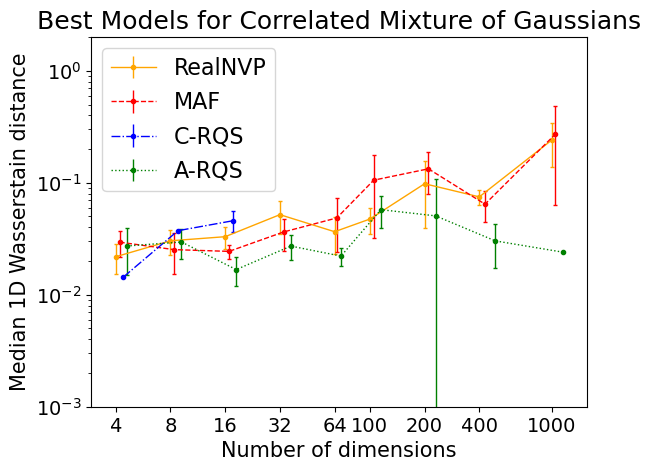

In [50]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_WD[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x0,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),1000)*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),1000)*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x2)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),1000)*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x3)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Median 1D Wasserstain distance', fontsize=fontsize_y)
plt.ylim(0.001,2)
plt.title("Best Models for Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_WD_median_corr.pdf')
plt.show()
plt.close()

In [53]:
#jtplot.reset()
#linewidth = 0.3
#point_label_size = 8
#point_marker = '.' #'go--'
#plt.plot(MsplineN_corr_WD[:,0],MsplineN_corr_WD[:,1],point_marker, color='green', label='Mspline (corr)', linestyle="-", linewidth=linewidth)
#for i in MsplineN_corr_WD:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
#plt.plot(MsplineN_uncorr_WD[:,0],MsplineN_uncorr_WD[:,1],point_marker, color='green', label='Mspline (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in MsplineN_uncorr_WD:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
#plt.plot(CsplineN_corr_WD[:,0],CsplineN_corr_WD[:,1],point_marker, color='blue', label='Cspline (corr)', linestyle="-", linewidth=linewidth)
#for i in CsplineN_corr_WD:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
#plt.plot(CsplineN_uncorr_WD[:,0],CsplineN_uncorr_WD[:,1],point_marker, color='blue', label='Cspline (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in CsplineN_uncorr_WD:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
#plt.plot(MAFN_corr_WD[:,0],MAFN_corr_WD[:,1],point_marker, color='red', label='MAF (corr)', linestyle="-", linewidth=linewidth)
#for i in MAFN_corr_WD:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
#plt.plot(MAFN_uncorr_WD[:,0],MAFN_uncorr_WD[:,1],point_marker, color='red', label='MAF (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in MAFN_uncorr_WD:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
#plt.plot(RealNVPN_corr_WD[:,0],RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP (corr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in RealNVPN_corr_WD:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
#plt.plot(RealNVPN_uncorr_WD[:,0],RealNVPN_uncorr_WD[:,1],point_marker, color='orange', label='RealNVP (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in RealNVPN_uncorr_WD:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('Number of dimensions')
#plt.ylabel('W-distance')
#plt.ylim(0,5)
#plt.title("Corr. MoG: median Wasserstein distance for best models")
##lt.ylim(max(MsplineN_corr_WD[:,1]), min(MsplineN_corr_WD[:,1]))
#plt.legend()
#plt.savefig(paper_fig_dir + 'Best_WD_median_corr.pdf')
#plt.show()
#plt.close()

### KS

In [58]:
MsplineN_corr_KS = extract_lines(df_bests_corr,"MsplineN","corr","ks_test_median")
MsplineN_uncorr_KS = extract_lines(df_bests_corr,"MsplineN","uncorr","ks_test_median")
CsplineN_corr_KS = extract_lines(df_bests_corr,"CsplineN","corr","ks_test_median")
CsplineN_uncorr_KS = extract_lines(df_bests_corr,"CsplineN","uncorr","ks_test_median")
MAFN_corr_KS = extract_lines(df_bests_corr,"MAFN","corr","ks_test_median")
MAFN_uncorr_KS = extract_lines(df_bests_corr,"MAFN","uncorr","ks_test_median")
RealNVPN_corr_KS = extract_lines(df_bests_corr,"RealNVPN","corr","ks_test_median")
RealNVPN_uncorr_KS = extract_lines(df_bests_corr,"RealNVPN","uncorr","ks_test_median")

/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame 

In [55]:
#KS_threshold=0.000000001
#MsplineN_corr_KS = np.array([x for x in MsplineN_corr_KS if x[1]>KS_threshold])
#MsplineN_uncorr_KS = np.array([x for x in MsplineN_uncorr_KS if x[1]>KS_threshold])
#CsplineN_corr_KS = np.array([x for x in CsplineN_corr_KS if x[1]>KS_threshold])
#CsplineN_uncorr_KS = np.array([x for x in CsplineN_uncorr_KS if x[1]>KS_threshold])
#MAFN_corr_KS = np.array([x for x in MAFN_corr_KS if x[1]>KS_threshold])
#MAFN_uncorr_KS = np.array([x for x in MAFN_uncorr_KS if x[1]>KS_threshold])
#RealNVPN_corr_KS = np.array([x for x in RealNVPN_corr_KS if x[1]>KS_threshold])
#RealNVPN_uncorr_KS = np.array([x for x in RealNVPN_uncorr_KS if x[1]>KS_threshold])

/tmp/ipykernel_89/2555757080.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_KS[:,0],RealNVPN_corr_KS[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
/tmp/ipykernel_89/2555757080.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_KS[:,0],RealNVPN_corr_KS[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
/tmp/ipykernel_89/2555757080.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(MAFN_corr_KS[:,0],MAFN_corr_KS[:,1],point_marker, color='red', label='MAF', linestyle="-", linewidth=l

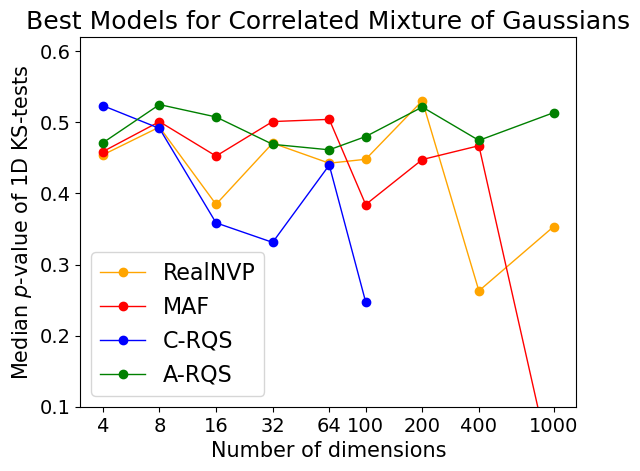

In [59]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = 'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
plt.plot(RealNVPN_corr_KS[:,0],RealNVPN_corr_KS[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.plot(MAFN_corr_KS[:,0],MAFN_corr_KS[:,1],point_marker, color='red', label='MAF', linestyle="-", linewidth=linewidth)
plt.plot(CsplineN_corr_KS[:,0],CsplineN_corr_KS[:,1],point_marker, color='blue', label='C-RQS', linestyle="-", linewidth=linewidth)
plt.plot(MsplineN_corr_KS[:,0],MsplineN_corr_KS[:,1],point_marker, color='green', label='A-RQS', linestyle="-", linewidth=linewidth)
if labels:
    for i in MsplineN_corr_KS:
        plt.text(i[0]*0.85,i[1]*1, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_KS:
        plt.text(i[0]*1.05,i[1]*0.98, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_KS:
        plt.text(i[0]*1.05,i[1]*1.01, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_KS:
        plt.text(i[0]*0.85,i[1]*0.98, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Median $p$-value of 1D KS-tests', fontsize=fontsize_y)
plt.ylim(0.1,0.62)
plt.title("Best Models for Correlated Mixture of Gaussians", fontsize=fontsize_title)
#lt.ylim(max(MsplineN_corr_WD[:,1]), min(MsplineN_corr_WD[:,1]))
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_KS_median_corr.pdf')
plt.show()
plt.close()

In [57]:
#jtplot.reset()
#linewidth = 0.3
#point_label_size = 8
#point_marker = '.' #'go--'
#plt.plot(MsplineN_corr_KS[:,0],MsplineN_corr_KS[:,1],point_marker, color='green', label='Mspline (corr)', linestyle="solid", linewidth=linewidth)
#for i in MsplineN_corr_KS:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
#plt.plot(MsplineN_uncorr_KS[:,0],MsplineN_uncorr_KS[:,1],point_marker, color='green', label='Mspline (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in MsplineN_uncorr_KS:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
#plt.plot(CsplineN_corr_KS[:,0],CsplineN_corr_KS[:,1],point_marker, color='blue', label='Cspline (corr)', linestyle="solid", linewidth=linewidth)
#for i in CsplineN_corr_KS:
#    plt.text(i[0]*1.05,i[1]*1.03, str(int(i[2])), fontsize=point_label_size, color='blue')
#plt.plot(CsplineN_uncorr_KS[:,0],CsplineN_uncorr_KS[:,1],point_marker, color='blue', label='Cspline (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in CsplineN_uncorr_KS:
#    plt.text(i[0]*1.05,i[1]*0.95, str(int(i[2])), fontsize=point_label_size, color='blue')
#plt.plot(MAFN_corr_KS[:,0],MAFN_corr_KS[:,1],point_marker, color='red', label='MAF (corr)', linestyle="solid", linewidth=linewidth)
#for i in MAFN_corr_KS:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
#plt.plot(MAFN_uncorr_KS[:,0],MAFN_uncorr_KS[:,1],point_marker, color='red', label='MAF (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in MAFN_uncorr_KS:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
#plt.plot(RealNVPN_corr_KS[:,0],RealNVPN_corr_KS[:,1],point_marker, color='orange', label='RealNVP (corr)', linestyle="solid", linewidth=linewidth)
#for i in RealNVPN_corr_KS:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
#plt.plot(RealNVPN_uncorr_KS[:,0],RealNVPN_uncorr_KS[:,1],point_marker, color='orange', label='RealNVP (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in RealNVPN_uncorr_KS:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
#plt.xscale('log')
##plt.yscale('log')
#plt.ylim(0.2,0.55)
#plt.title("Corr. MoG: median p-value of KS-test for best models")
##lt.ylim(max(MsplineN_corr_WD[:,1]), min(MsplineN_corr_WD[:,1]))
#plt.legend()
#plt.savefig(paper_fig_dir + 'Best_KS_median_corr.pdf')
#plt.show()
#plt.close()

### Frobenius-norm

In [53]:
MsplineN_corr_FN = extract_lines(df_bests_corr,"MsplineN","corr","frob_norm")
MsplineN_uncorr_FN = extract_lines(df_bests_corr,"MsplineN","uncorr","frob_norm")
CsplineN_corr_FN = extract_lines(df_bests_corr,"CsplineN","corr","frob_norm")
CsplineN_uncorr_FN = extract_lines(df_bests_corr,"CsplineN","uncorr","frob_norm")
MAFN_corr_FN = extract_lines(df_bests_corr,"MAFN","corr","frob_norm")
MAFN_uncorr_FN = extract_lines(df_bests_corr,"MAFN","uncorr","frob_norm")
RealNVPN_corr_FN = extract_lines(df_bests_corr,"RealNVPN","corr","frob_norm")
RealNVPN_uncorr_FN = extract_lines(df_bests_corr,"RealNVPN","uncorr","frob_norm")

/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame 

/tmp/ipykernel_89/2671916003.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_FN[:,0],RealNVPN_corr_FN[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
/tmp/ipykernel_89/2671916003.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_FN[:,0],RealNVPN_corr_FN[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
/tmp/ipykernel_89/2671916003.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(MAFN_corr_FN[:,0],MAFN_corr_FN[:,1],point_marker, color='red', label='MAF', linestyle="-", linewidth=l

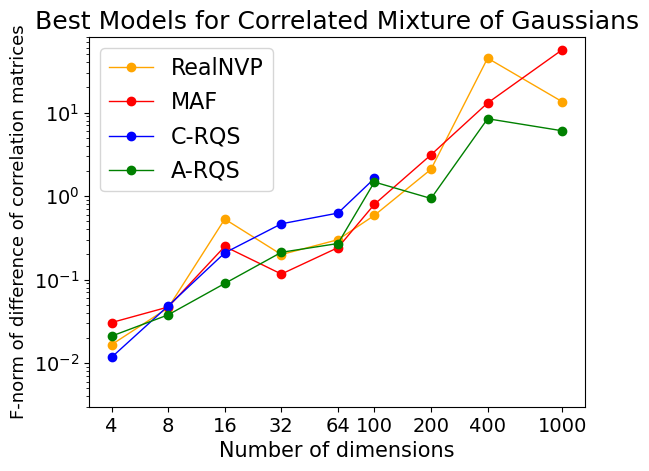

In [55]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = 'go--'#'.'
fontsize_x=15
fontsize_y=13
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
plt.plot(RealNVPN_corr_FN[:,0],RealNVPN_corr_FN[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.plot(MAFN_corr_FN[:,0],MAFN_corr_FN[:,1],point_marker, color='red', label='MAF', linestyle="-", linewidth=linewidth)
plt.plot(CsplineN_corr_FN[:,0],CsplineN_corr_FN[:,1],point_marker, color='blue', label='C-RQS', linestyle="-", linewidth=linewidth)
plt.plot(MsplineN_corr_FN[:,0],MsplineN_corr_FN[:,1],point_marker, color='green', label='A-RQS', linestyle="-", linewidth=linewidth)
if labels:
    for i in MsplineN_corr_FN:
        plt.text(i[0]*0.85,i[1]*1, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_FN:
        plt.text(i[0]*1.05,i[1]*1.03, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_FN:
        plt.text(i[0]*1.05,i[1]*0.8, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_FN:
        plt.text(i[0]*0.85,i[1]*0.75, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('F-norm of difference of correlation matrices', fontsize=fontsize_y)
plt.ylim(0.003,80)
plt.title("Best Models for Correlated Mixture of Gaussians", fontsize=fontsize_title)
#lt.ylim(max(MsplineN_corr_WD[:,1]), min(MsplineN_corr_WD[:,1]))
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_FN_corr.pdf')
plt.show()
plt.close()

### Training time

In [61]:
MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","corr","time").astype(np.float)
MsplineN_uncorr_time = extract_lines(df_bests_corr,"MsplineN","uncorr","time").astype(np.float)
CsplineN_corr_time = extract_lines(df_bests_corr,"CsplineN","corr","time").astype(np.float)
CsplineN_uncorr_time = extract_lines(df_bests_corr,"CsplineN","uncorr","time").astype(np.float)
MAFN_corr_time = extract_lines(df_bests_corr,"MAFN","corr","time").astype(np.float)
MAFN_uncorr_time = extract_lines(df_bests_corr,"MAFN","uncorr","time").astype(np.float)
RealNVPN_corr_time = extract_lines(df_bests_corr,"RealNVPN","corr","time").astype(np.float)
RealNVPN_uncorr_time = extract_lines(df_bests_corr,"RealNVPN","uncorr","time").astype(np.float)

/tmp/ipykernel_89/1461121621.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","corr","time").astype(np.float)
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: B

/tmp/ipykernel_89/1104397445.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_time[:,0],RealNVPN_corr_time[:,1],point_marker, color='orange', label='RealNVP', linestyle="solid", linewidth=linewidth)
/tmp/ipykernel_89/1104397445.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_time[:,0],RealNVPN_corr_time[:,1],point_marker, color='orange', label='RealNVP', linestyle="solid", linewidth=linewidth)
/tmp/ipykernel_89/1104397445.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(MAFN_corr_time[:,0],MAFN_corr_time[:,1],point_marker, color='red', label='MAF', linest

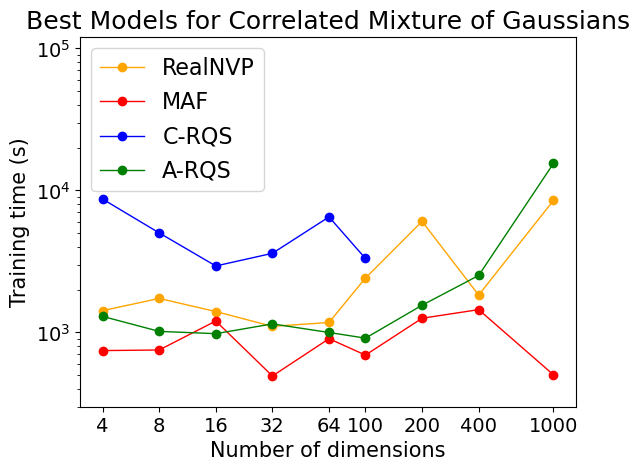

In [68]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = 'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
plt.plot(RealNVPN_corr_time[:,0],RealNVPN_corr_time[:,1],point_marker, color='orange', label='RealNVP', linestyle="solid", linewidth=linewidth)
plt.plot(MAFN_corr_time[:,0],MAFN_corr_time[:,1],point_marker, color='red', label='MAF', linestyle="solid", linewidth=linewidth)
plt.plot(CsplineN_corr_time[:,0],CsplineN_corr_time[:,1],point_marker, color='blue', label='C-RQS', linestyle="solid", linewidth=linewidth)
plt.plot(MsplineN_corr_time[:,0],MsplineN_corr_time[:,1],point_marker, color='green', label='A-RQS', linestyle="solid", linewidth=linewidth)
if labels:
    for i in MsplineN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_time:
        plt.text(i[0]*1.05,i[1]*1.03, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_time:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Training time (s)', fontsize=fontsize_y)
plt.ylim(300,120000)
plt.title("Best Models for Correlated Mixture of Gaussians", fontsize=fontsize_title)
#lt.ylim(max(MsplineN_corr_WD[:,1]), min(MsplineN_corr_WD[:,1]))
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_training_time_corr.pdf')
plt.show()
plt.close()

## Tables

In [143]:
df_bests_corr[0]

,run_n,run_seed,ndims,nsamples,correlation,nbijectors,bijector,activation,spline_knots,range_min,eps_regulariser,regulariser,kl_divergence,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,sliced_Wasserstein_mean,sliced_Wasserstein_std,sliced_Wasserstein_mean_mean,sliced_Wasserstein_mean_std,nruns,frob_norm,hidden_layers,batch_size,epochs_input,epochs_output,time
0,4,0,4,100000,corr,2,MsplineN,relu,12,-16,0,None,-1,0.484862,0.483977,0.215978,0.214231,0.015517,0.005144,0.026894,0.009631,10,0.020662,256-256-256,512,1000,237,1297.448962
1,7,0,4,100000,corr,10,CsplineN,relu,8,-16,0,None,-1,0.525661,0.523440,0.222253,0.222633,0.016277,0.005755,0.023468,0.007149,5,0.014546,128-128-128,512,1000,289,14023.302548
5,4,0,4,100000,corr,10,RealNVPN,relu,8,-5,0,None,-1,0.506393,0.509441,0.219049,0.220097,0.019917,0.007522,0.022365,0.004709,10,0.007750,256-256-256,256,1000,337,3307.465860
8,2,0,4,100000,corr,5,MAFN,relu,8,-5,0,None,-1,0.504421,0.518005,0.223863,0.221983,0.021769,0.007086,0.028155,0.007063,10,0.023668,256-256-256,512,1000,361,833.398603


In [150]:
for index, row in tmp.iterrows():
    if row["bijector"]=="RealNVPN":
        print(row["spline_knots"])
        row["spline_knots"]="--"
tmp

8
8
8
8
8
8
8
8
8


,run_n,run_seed,ndims,nsamples,correlation,nbijectors,bijector,activation,spline_knots,range_min,eps_regulariser,regulariser,kl_divergence,ks_test_mean,ks_test_median,ad_test_mean,ad_test_median,sliced_Wasserstein_mean,sliced_Wasserstein_std,sliced_Wasserstein_mean_mean,sliced_Wasserstein_mean_std,nruns,frob_norm,hidden_layers,batch_size,epochs_input,epochs_output,time
0,4,0,4,100000,corr,2,MsplineN,relu,12,-16,0,None,-1,0.484862,0.483977,0.215978,0.214231,0.015517,0.005144,0.026894,0.009631,10,0.020662,256-256-256,512,1000,237,1297.448962
1,7,0,4,100000,corr,10,CsplineN,relu,8,-16,0,None,-1,0.525661,0.523440,0.222253,0.222633,0.016277,0.005755,0.023468,0.007149,5,0.014546,128-128-128,512,1000,289,14023.302548
5,4,0,4,100000,corr,10,RealNVPN,relu,8,-5,0,None,-1,0.506393,0.509441,0.219049,0.220097,0.019917,0.007522,0.022365,0.004709,10,0.007750,256-256-256,256,1000,337,3307.465860
8,2,0,4,100000,corr,5,MAFN,relu,8,-5,0,None,-1,0.504421,0.518005,0.223863,0.221983,0.021769,0.007086,0.028155,0.007063,10,0.023668,256-256-256,512,1000,361,833.398603
0,5,0,8,100000,corr,5,RealNVPN,relu,8,-5,0,None,-1,0.492637,0.494321,0.222382,0.221196,0.024380,0.010610,0.039468,0.011059,10,0.043682,128-128-128,256,1000,325,1735.637263
1,7,0,8,100000,corr,10,MAFN,relu,8,-5,0,None,-1,0.471417,0.479054,0.218443,0.215214,0.025050,0.008638,0.030646,0.015187,9,0.048585,128-128-128,512,1000,296,1794.298420
3,7,0,8,100000,corr,2,MsplineN,relu,12,-16,0,None,-1,0.483736,0.483878,0.220761,0.219416,0.028645,0.013518,0.032469,0.011304,10,0.036696,128-128-128,512,1000,190,1017.419504
4,16,0,8,100000,corr,5,CsplineN,relu,12,-16,0,None,-1,0.489789,0.481729,0.214252,0.211909,0.029197,0.014365,0.045916,0.020785,7,0.046413,128-128-128,512,1000,198,5022.062892
0,9,0,16,100000,corr,2,MsplineN,relu,8,-16,0,None,-1,0.522125,0.536895,0.222933,0.221640,0.015283,0.005522,0.022325,0.005915,10,0.079655,128-128-128,512,1000,184,980.492019
1,10,0,16,100000,corr,5,MAFN,relu,8,-5,0,None,-1,0.488434,0.495043,0.215383,0.213272,0.025364,0.011847,0.029399,0.004381,5,0.548248,256-256-256,512,1000,326,914.736928


In [204]:
tmp=df_bests_corr[0]
tmp=tmp[tmp["correlation"]=="corr"]
tmp=tmp[["hidden_layers","nbijectors","bijector","spline_knots","sliced_Wasserstein_mean", "ks_test_median", "frob_norm","epochs_output","time"]]
tmp["sliced_Wasserstein_mean"]=tmp["sliced_Wasserstein_mean"].apply(lambda x: "{:.2e}".format(float(x)))
tmp["ks_test_median"]=tmp["ks_test_median"].apply(lambda x: "{:.2e}".format(float(x)))
tmp["frob_norm"]=tmp["frob_norm"].apply(lambda x: "{:.2e}".format(float(x)))
tmp["time"]=tmp["time"].apply(lambda x: int(float(x)))
tmp.loc[tmp["bijector"]=="RealNVPN","spline_knots"]="--"
tmp.loc[tmp["bijector"]=="MAFN","spline_knots"]="--"
tmp.replace("MsplineN","A-RQS")
tmp.replace("CsplineN","C-RQS")
tmp.replace("RealNVPN","RealNVP")
tmp.replace("MAFN","MAF")
tmp['hidden_layers'] = tmp['hidden_layers'].str.replace(r'(\d+)-(\d+)-(\d+)', r'$3\times \1$', regex=True)
string=tmp.to_latex(index=False)
print(string)

\begin{tabular}{lrlllllrr}
\toprule
hidden\_layers &  nbijectors & bijector & spline\_knots & sliced\_Wasserstein\_mean & ks\_test\_median & frob\_norm &  epochs\_output &  time \\
\midrule
\$3\textbackslash times 256\$ &           2 & MsplineN &           12 &                1.55e-02 &       4.84e-01 &  2.07e-02 &            237 &  1297 \\
\$3\textbackslash times 128\$ &          10 & CsplineN &            8 &                1.63e-02 &       5.23e-01 &  1.45e-02 &            289 & 14023 \\
\$3\textbackslash times 256\$ &          10 & RealNVPN &           -- &                1.99e-02 &       5.09e-01 &  7.75e-03 &            337 &  3307 \\
\$3\textbackslash times 256\$ &           5 &     MAFN &           -- &                2.18e-02 &       5.18e-01 &  2.37e-02 &            361 &   833 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_4688/211014991.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  string=tmp.to_latex(index=False)


In [168]:
tmp.loc[df["bijector"]=="RealNVPN","spline_knots"]

1    --
8    --
Name: spline_knots, dtype: object

# Re-evaluate models

In [47]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    reset_random_seeds(0)
    ncomp=3
    ntest_samples=100000
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()
    start=timer()
    ks_mean,ks_std,ad_mean,ad_std,,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'kl_divergence':[kl_divergence],
                    'ks_test_mean':[ks_mean],
                    'ks_test_median':[ks_median],
                    'ad_test_mean':[ad_mean],
                    'ad_test_median':[ad_median],
                    'Wasserstein_median':[w_distance_median],
                    'Wasserstein_mean':[w_distance_mean],
                    'sliced_Wasserstein_mean':[swd_mean],
                    'sliced_Wasserstein_std':[swd_std],
                    'frob_norm':[frob_norm],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    os.rename(run, run.replace(".txt","_old.txt"))
    Utils.results_current(run.replace("results.txt",""),results_dict)
    tmp_new = pd.read_csv(run)
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp

In [48]:
run=list(correlated_unc_results_paths.values())[0]+"4D/run_5/results.txt"
pd.read_csv(run)
recompute_metrics(run)

Recomputing metrics for run ../CMoG/results/MAFN_best/4D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]


Metrics for run ../CMoG/results/MAFN_best/4D/run_5/ computed and saved in 1.2691607510000722 s.


,run_n,run_seed,ndims,nsamples,correlation,nbijectors,bijector,activation,spline_knots,range_min,...,Wasserstein_median,Wasserstein_mean,sliced_Wasserstein_mean,sliced_Wasserstein_std,frob_norm,hidden_layers,batch_size,epochs_input,epochs_output,time
0,5,520,4,100000,corr,5,MAFN,relu,8,-5,...,0.025781,0.025781,0.017306,0.001822,0.010386,128-128-128,512,1000,652,7184.605105


In [105]:
tmp=
X_data_nf = np.load(list(correlated_unc_results_paths.values())[0]+"4D/run_5/nf_sample.npy")
np.shape(X_data_nf)
#arg_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
#X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()

(100000, 4)

In [106]:
ndims=4
reset_random_seeds(0)

### Initialize number of components ###
def MixtureGaussian(ncomp,ndims,seed=0):
    targ_dist = MixtureDistributions.MixMultiNormal1(ncomp,ndims,seed=seed)
    return targ_dist
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()
np.shape(X_data_test)
X_data_test[0]

array([4.2423981 , 7.12590057, 6.06101175, 9.83516205])

In [107]:
ks_mean,ks_std,ad_mean,ad_std,,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
{'kl_divergence': kl_divergence,'ks_test_mean': ks_mean,'ks_test_median':ks_median,'ad_test_mean':ad_mean,'ad_test_median':ad_median,'Wasserstein_median':w_distance_median,'Wasserstein_mean':w_distance_mean,'frob_norm':frob_norm}

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]


{'kl_divergence': -1,
 'ks_test_mean': 0.5001360132927927,
 'ks_test_median': 0.5071681592536929,
 'ad_test_mean': 0.20878356996181632,
 'ad_test_median': 0.21184494329967268,
 'Wasserstein_median': 0.02578086762691431,
 'Wasserstein_mean': 0.02578086762691431,
 'frob_norm': 0.010386194116092153}

# Old

In [151]:
# Set random seed for reproducibility
np.random.seed(42)

# Define mean and covariance matrices
mean1 = np.random.randn(1000)
cov1 = np.random.randn(1000,1000)
mean2 = np.random.randn(1000)
cov2 = np.random.randn(1000,1000)

# Generate two MVN random samples with same mean and covariance
n_samples = 100000
sample1 = np.random.multivariate_normal(mean1, cov1, size=n_samples)
sample2 = np.random.multivariate_normal(mean2, cov2, size=n_samples)

/tmp/ipykernel_10662/2417459388.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  sample1 = np.random.multivariate_normal(mean1, cov1, size=n_samples)
/tmp/ipykernel_10662/2417459388.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  sample2 = np.random.multivariate_normal(mean2, cov2, size=n_samples)


In [152]:
from scipy.stats import wasserstein_distance
from timeit import default_timer as timer

In [155]:
start=timer()
res = np.mean([wasserstein_distance(sample1[:,0],sample2[:,0]),wasserstein_distance(sample1[:,1],sample2[:,1])])
end=timer()
print(res)
print("SWD computed in",end-start,"s.")

0.3611000457556382
SWD computed in 0.11974661500426009 s.


In [156]:
n_slices=[10,20,30,50,100]
means=[]
stds=[]
for i in n_slices:
    print("Computing SWD for",i,"slices")
    start=timer()
    swd=[sliced_Wasserstein_distance(sample1, sample2, norm=True, n_slices=i, p=1, seed=None) for k in range(10)]
    means.append(np.mean(swd))
    stds.append(np.std(swd))
    end=timer()
    print("SWD for",i,"slices computed in",end-start,"s.")

Computing SWD for 10 slices
SWD for 10 slices computed in 13.37087254099606 s.
Computing SWD for 20 slices
SWD for 20 slices computed in 28.011276363991783 s.
Computing SWD for 30 slices
SWD for 30 slices computed in 42.616360687999986 s.
Computing SWD for 50 slices
SWD for 50 slices computed in 69.60400968199247 s.
Computing SWD for 100 slices
SWD for 100 slices computed in 135.5928650309943 s.


In [157]:
means

[1.1240666444239884,
 1.178620028730426,
 1.0345398202687348,
 1.0856285500872462,
 1.1349826566549233]

In [158]:
stds

[0.2821306524675983,
 0.24819902027034105,
 0.13102079479750936,
 0.13262808573039866,
 0.10346581086159876]